In [1]:
import json_tools
import os
import plotting_tools
from hipe4ml.model_handler import ModelHandler
import fasttreeshap as shap
import pandas as pd

/opt/homebrew/Caskroom/miniforge/base/envs/cbm22/lib/python3.8/site-packages/fasttreeshap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/Caskroom/miniforge/base/envs/cbm22/lib/python3.8/site-packages/fasttreeshap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-whe

In [2]:
json_file_name ="config.json"
model_name = "model_0.0_1.6_positive"
model_dir = f"/Users/julnow/gsi/ml-pid-cbm/ml_pid_cbm/only_tof/mass2/0sigma/{model_name}"
os.chdir(model_dir)
df = pd.read_pickle(f"{model_dir}/validated_data.pickle")


Let's check xgb-selected proton in the first bin, from p =0-1.6 GeV/c

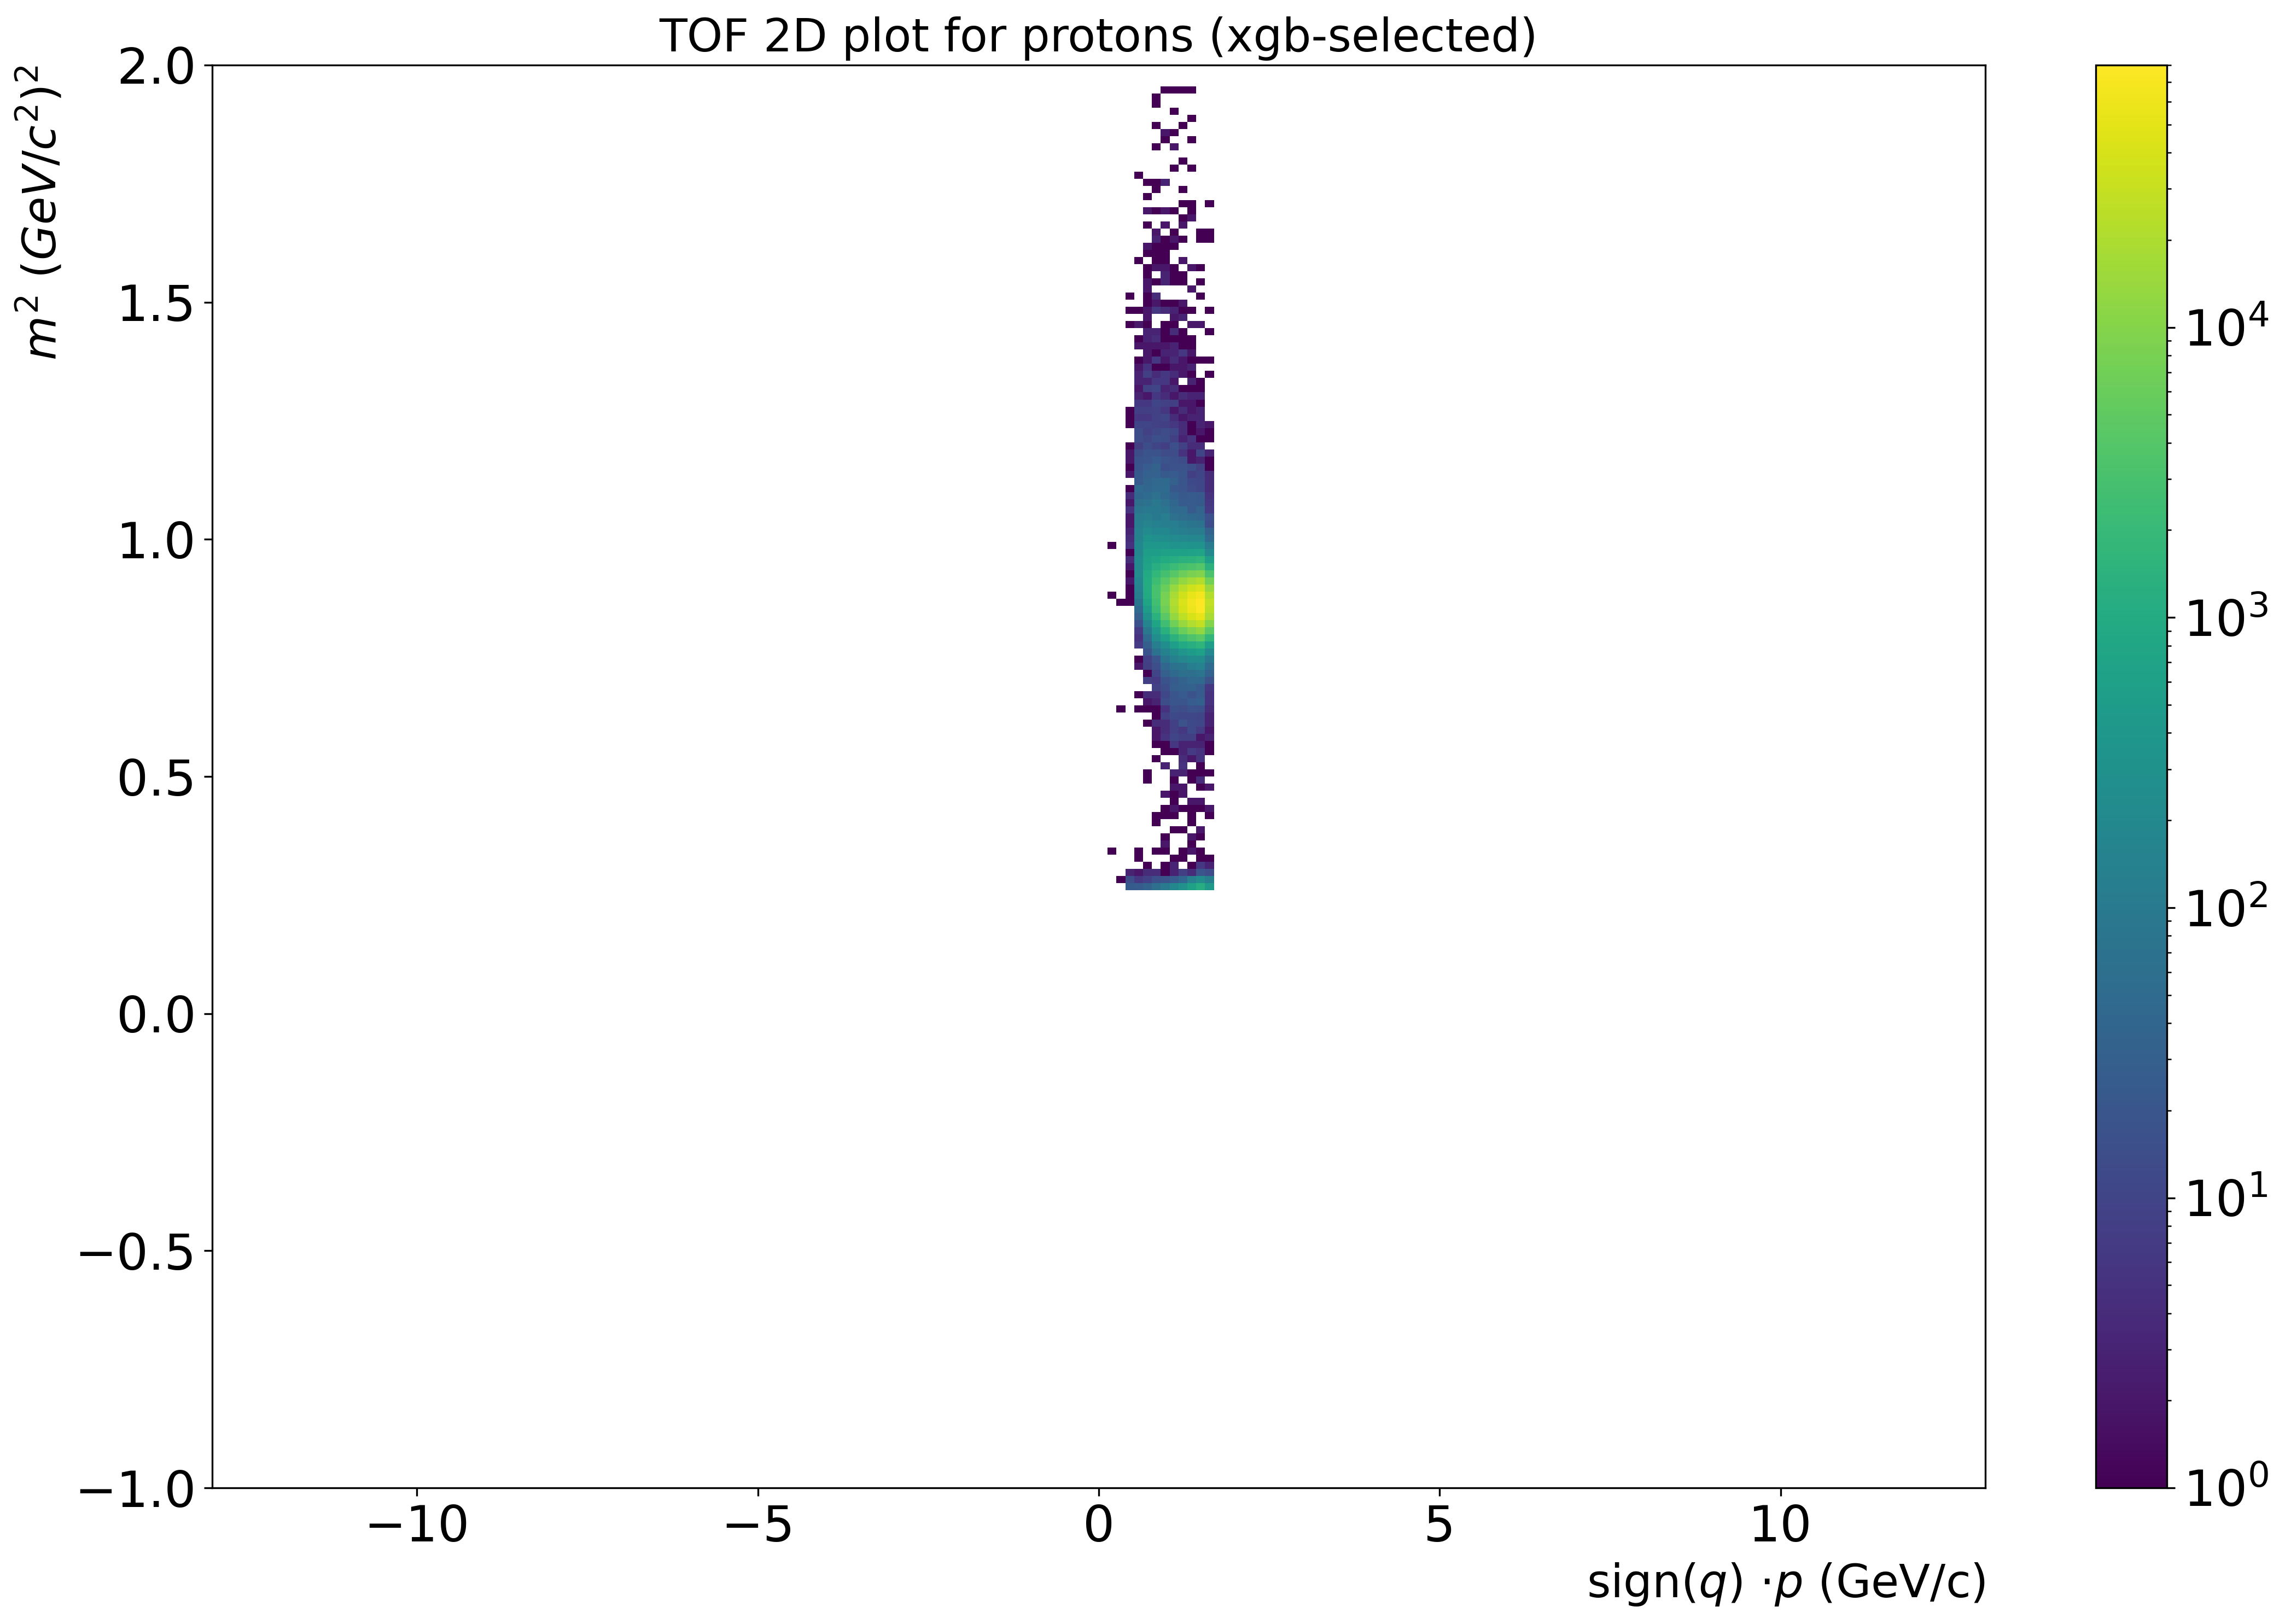

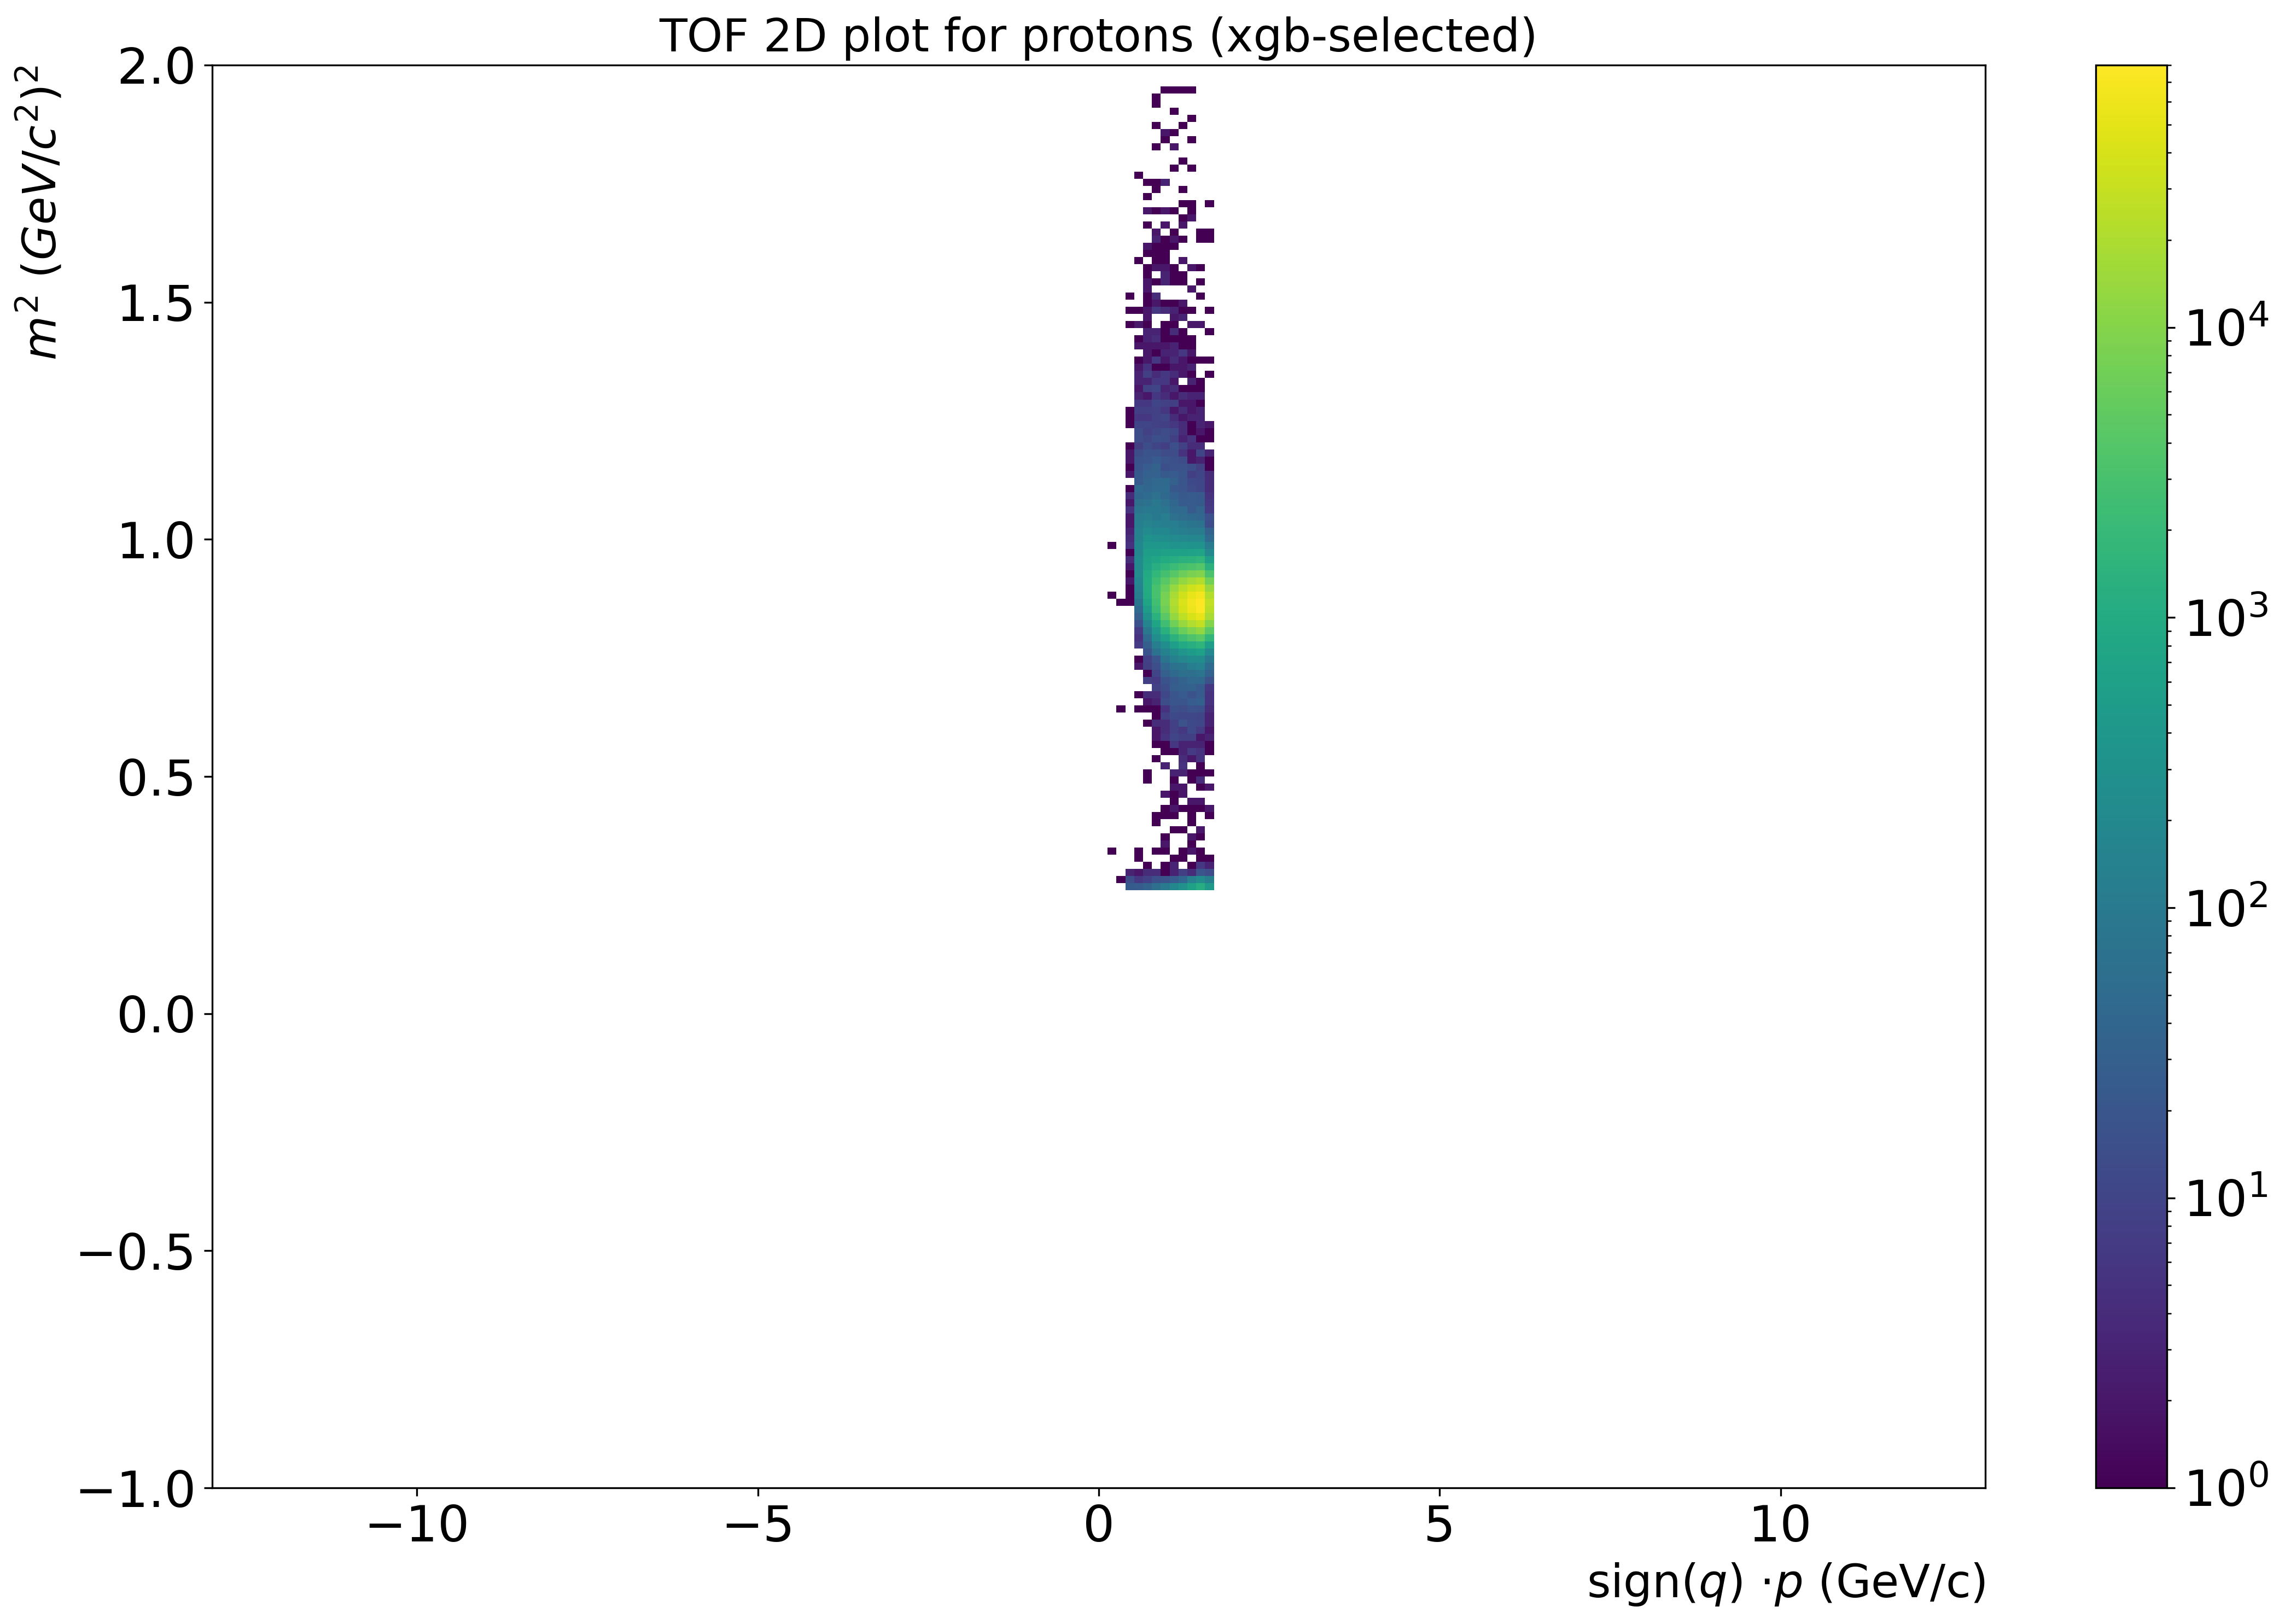

In [3]:
plotting_tools.tof_plot(
            df[df["xgb_preds"] == 0],
            json_file_name,
            f"protons (xgb-selected)",
            save_fig=False,
        )

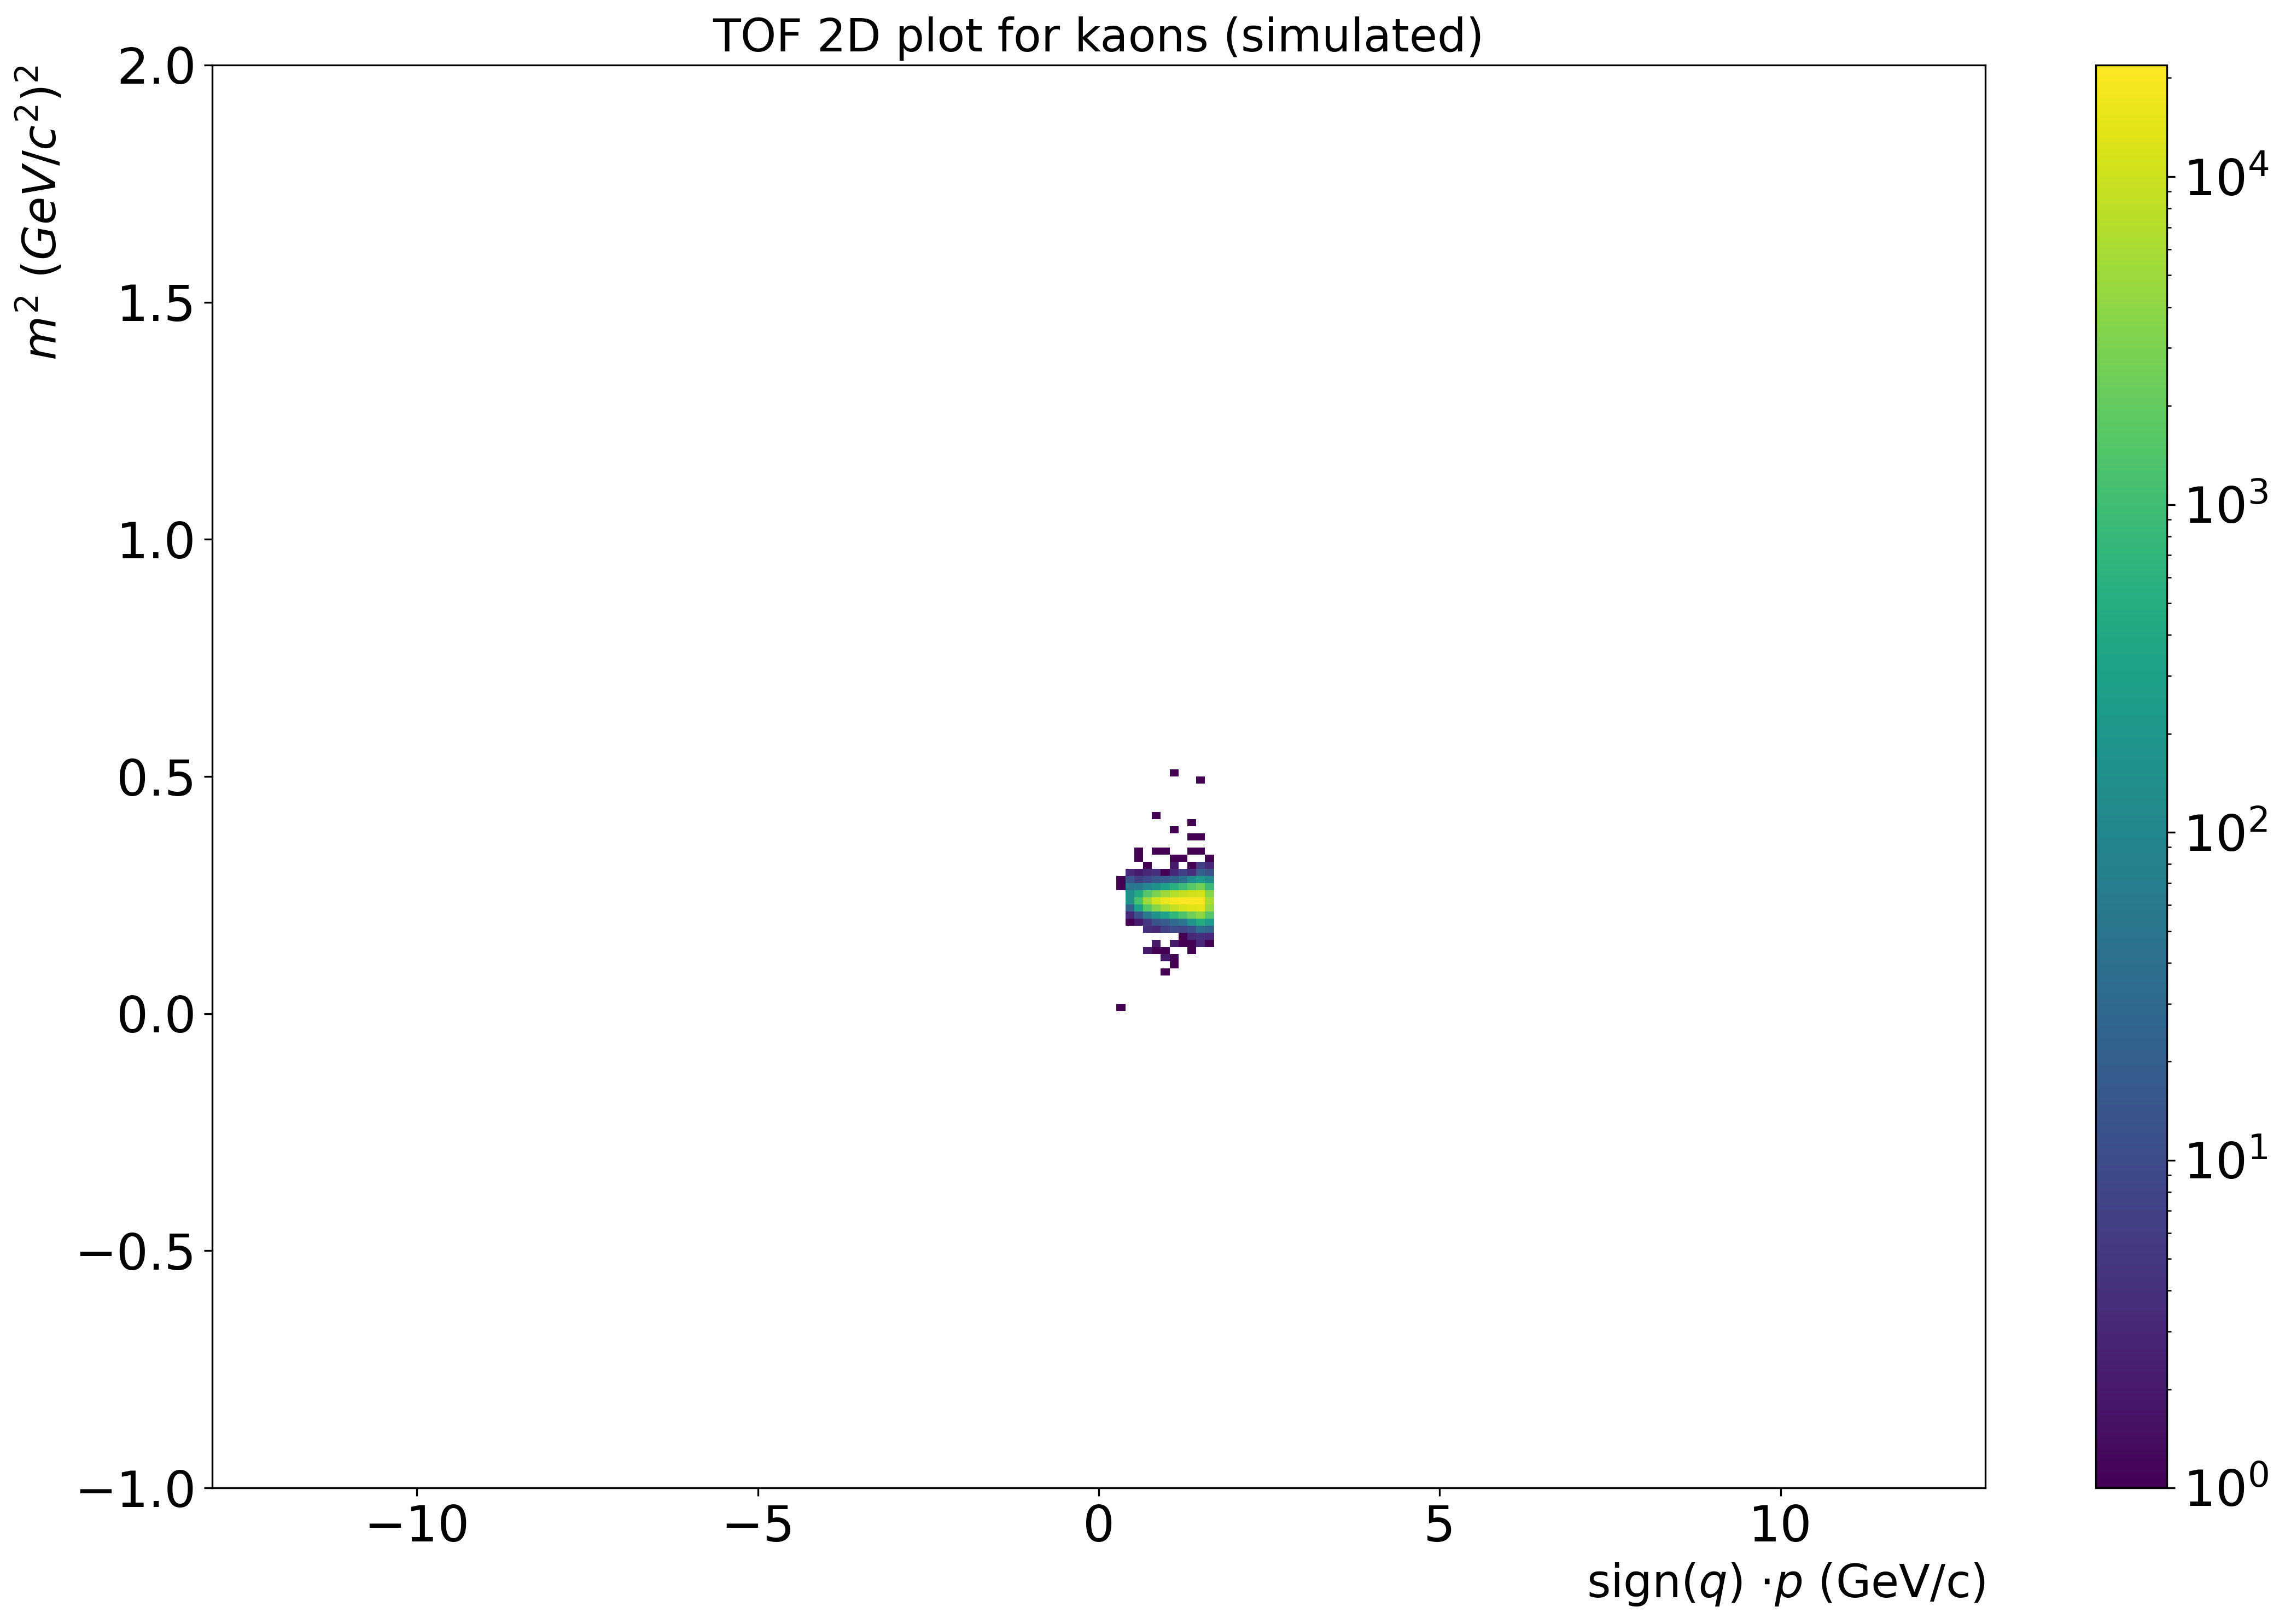

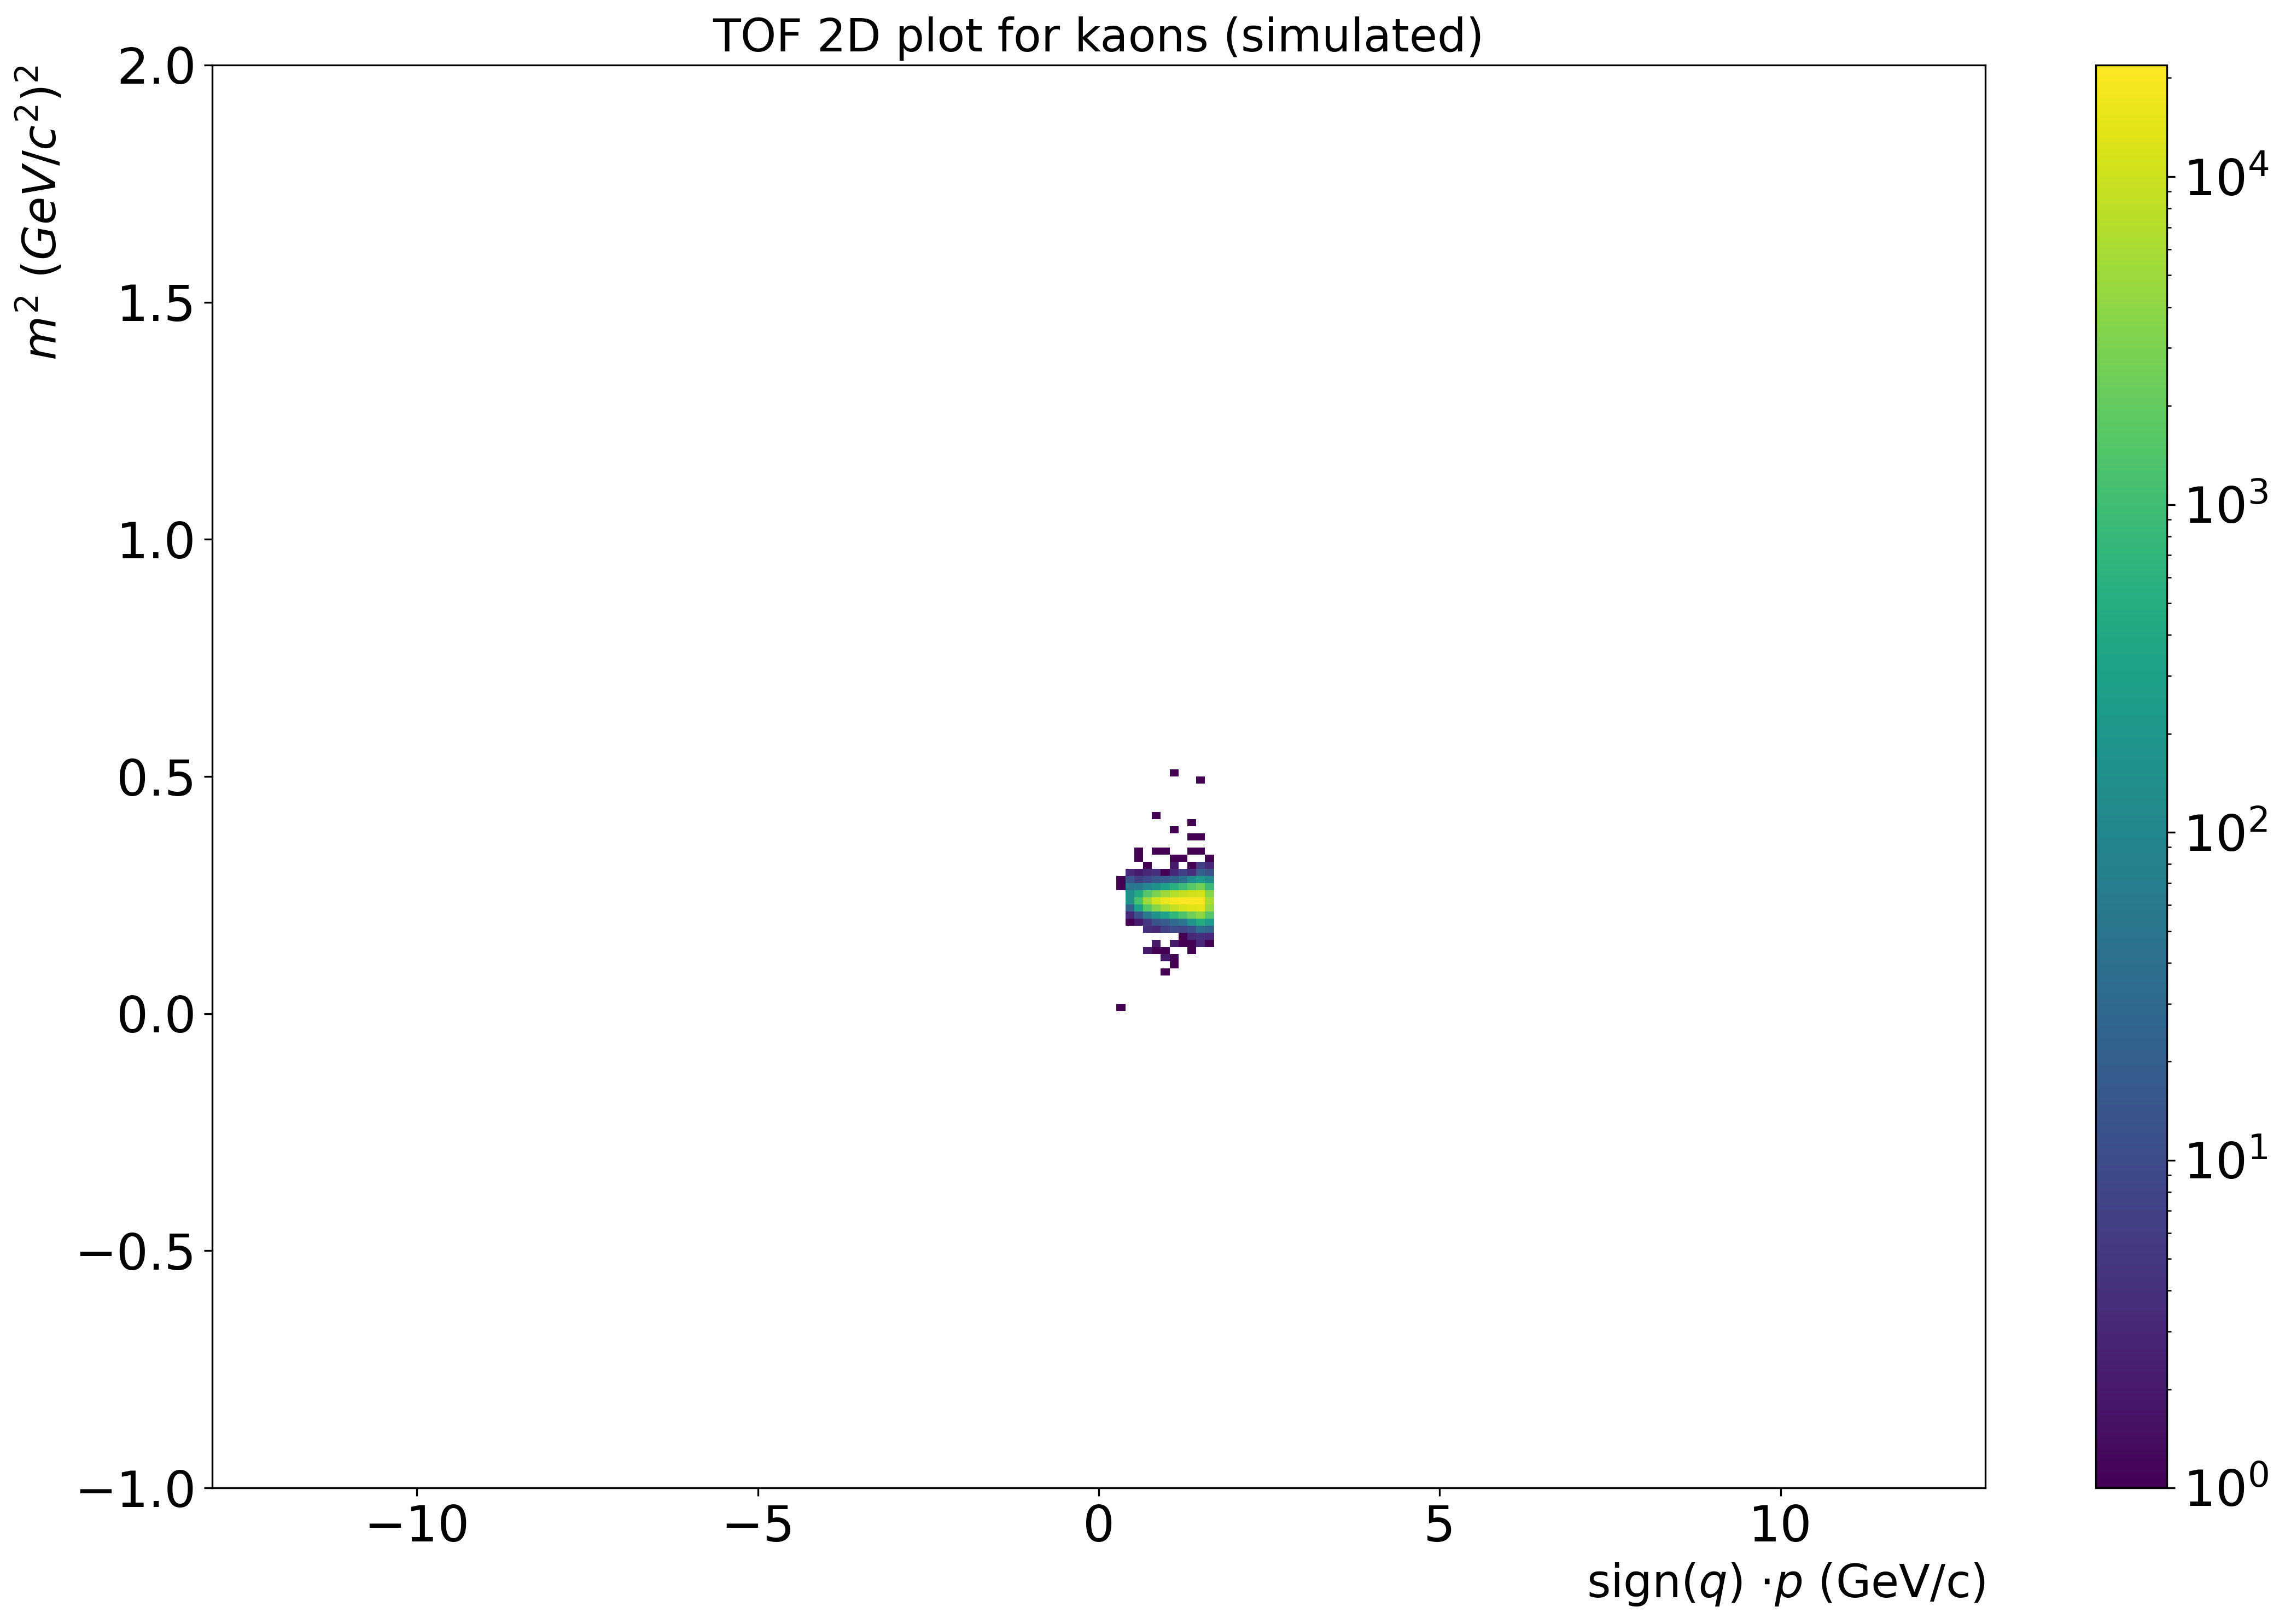

In [4]:
plotting_tools.tof_plot(
            df[df["Complex_pid"] == 1],
            json_file_name,
            f"kaons (simulated)",
            save_fig=False,
        )

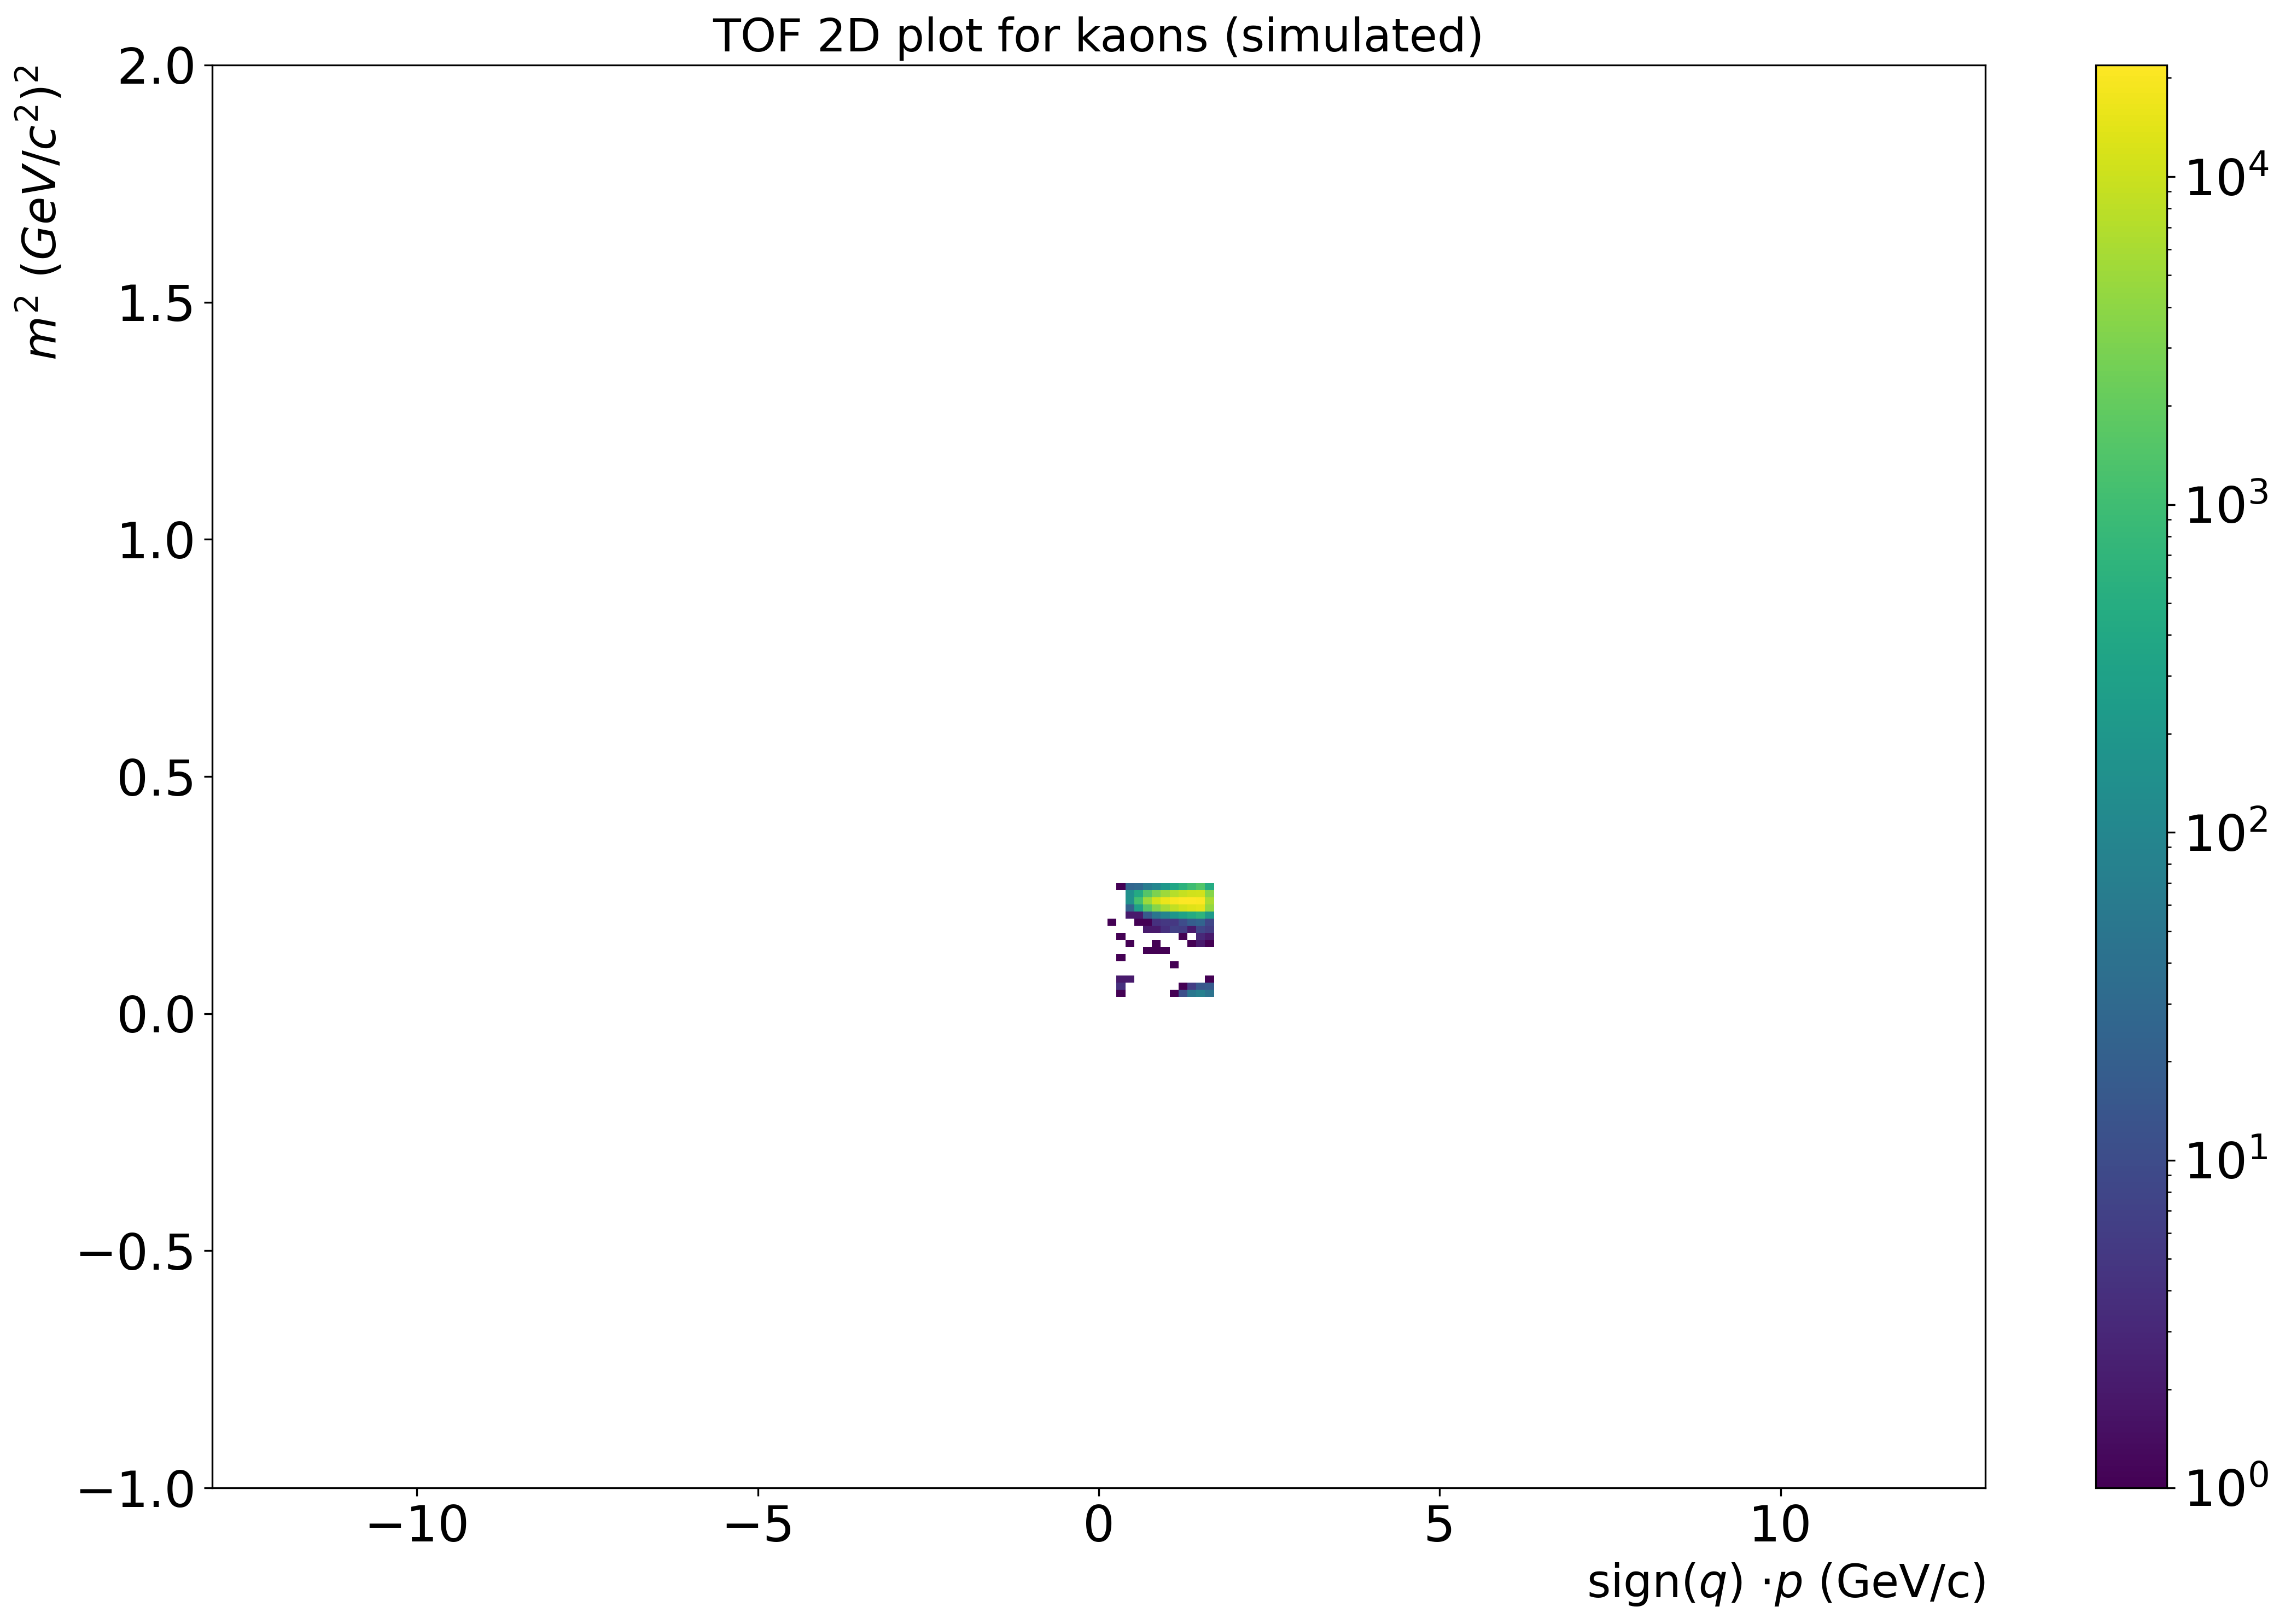

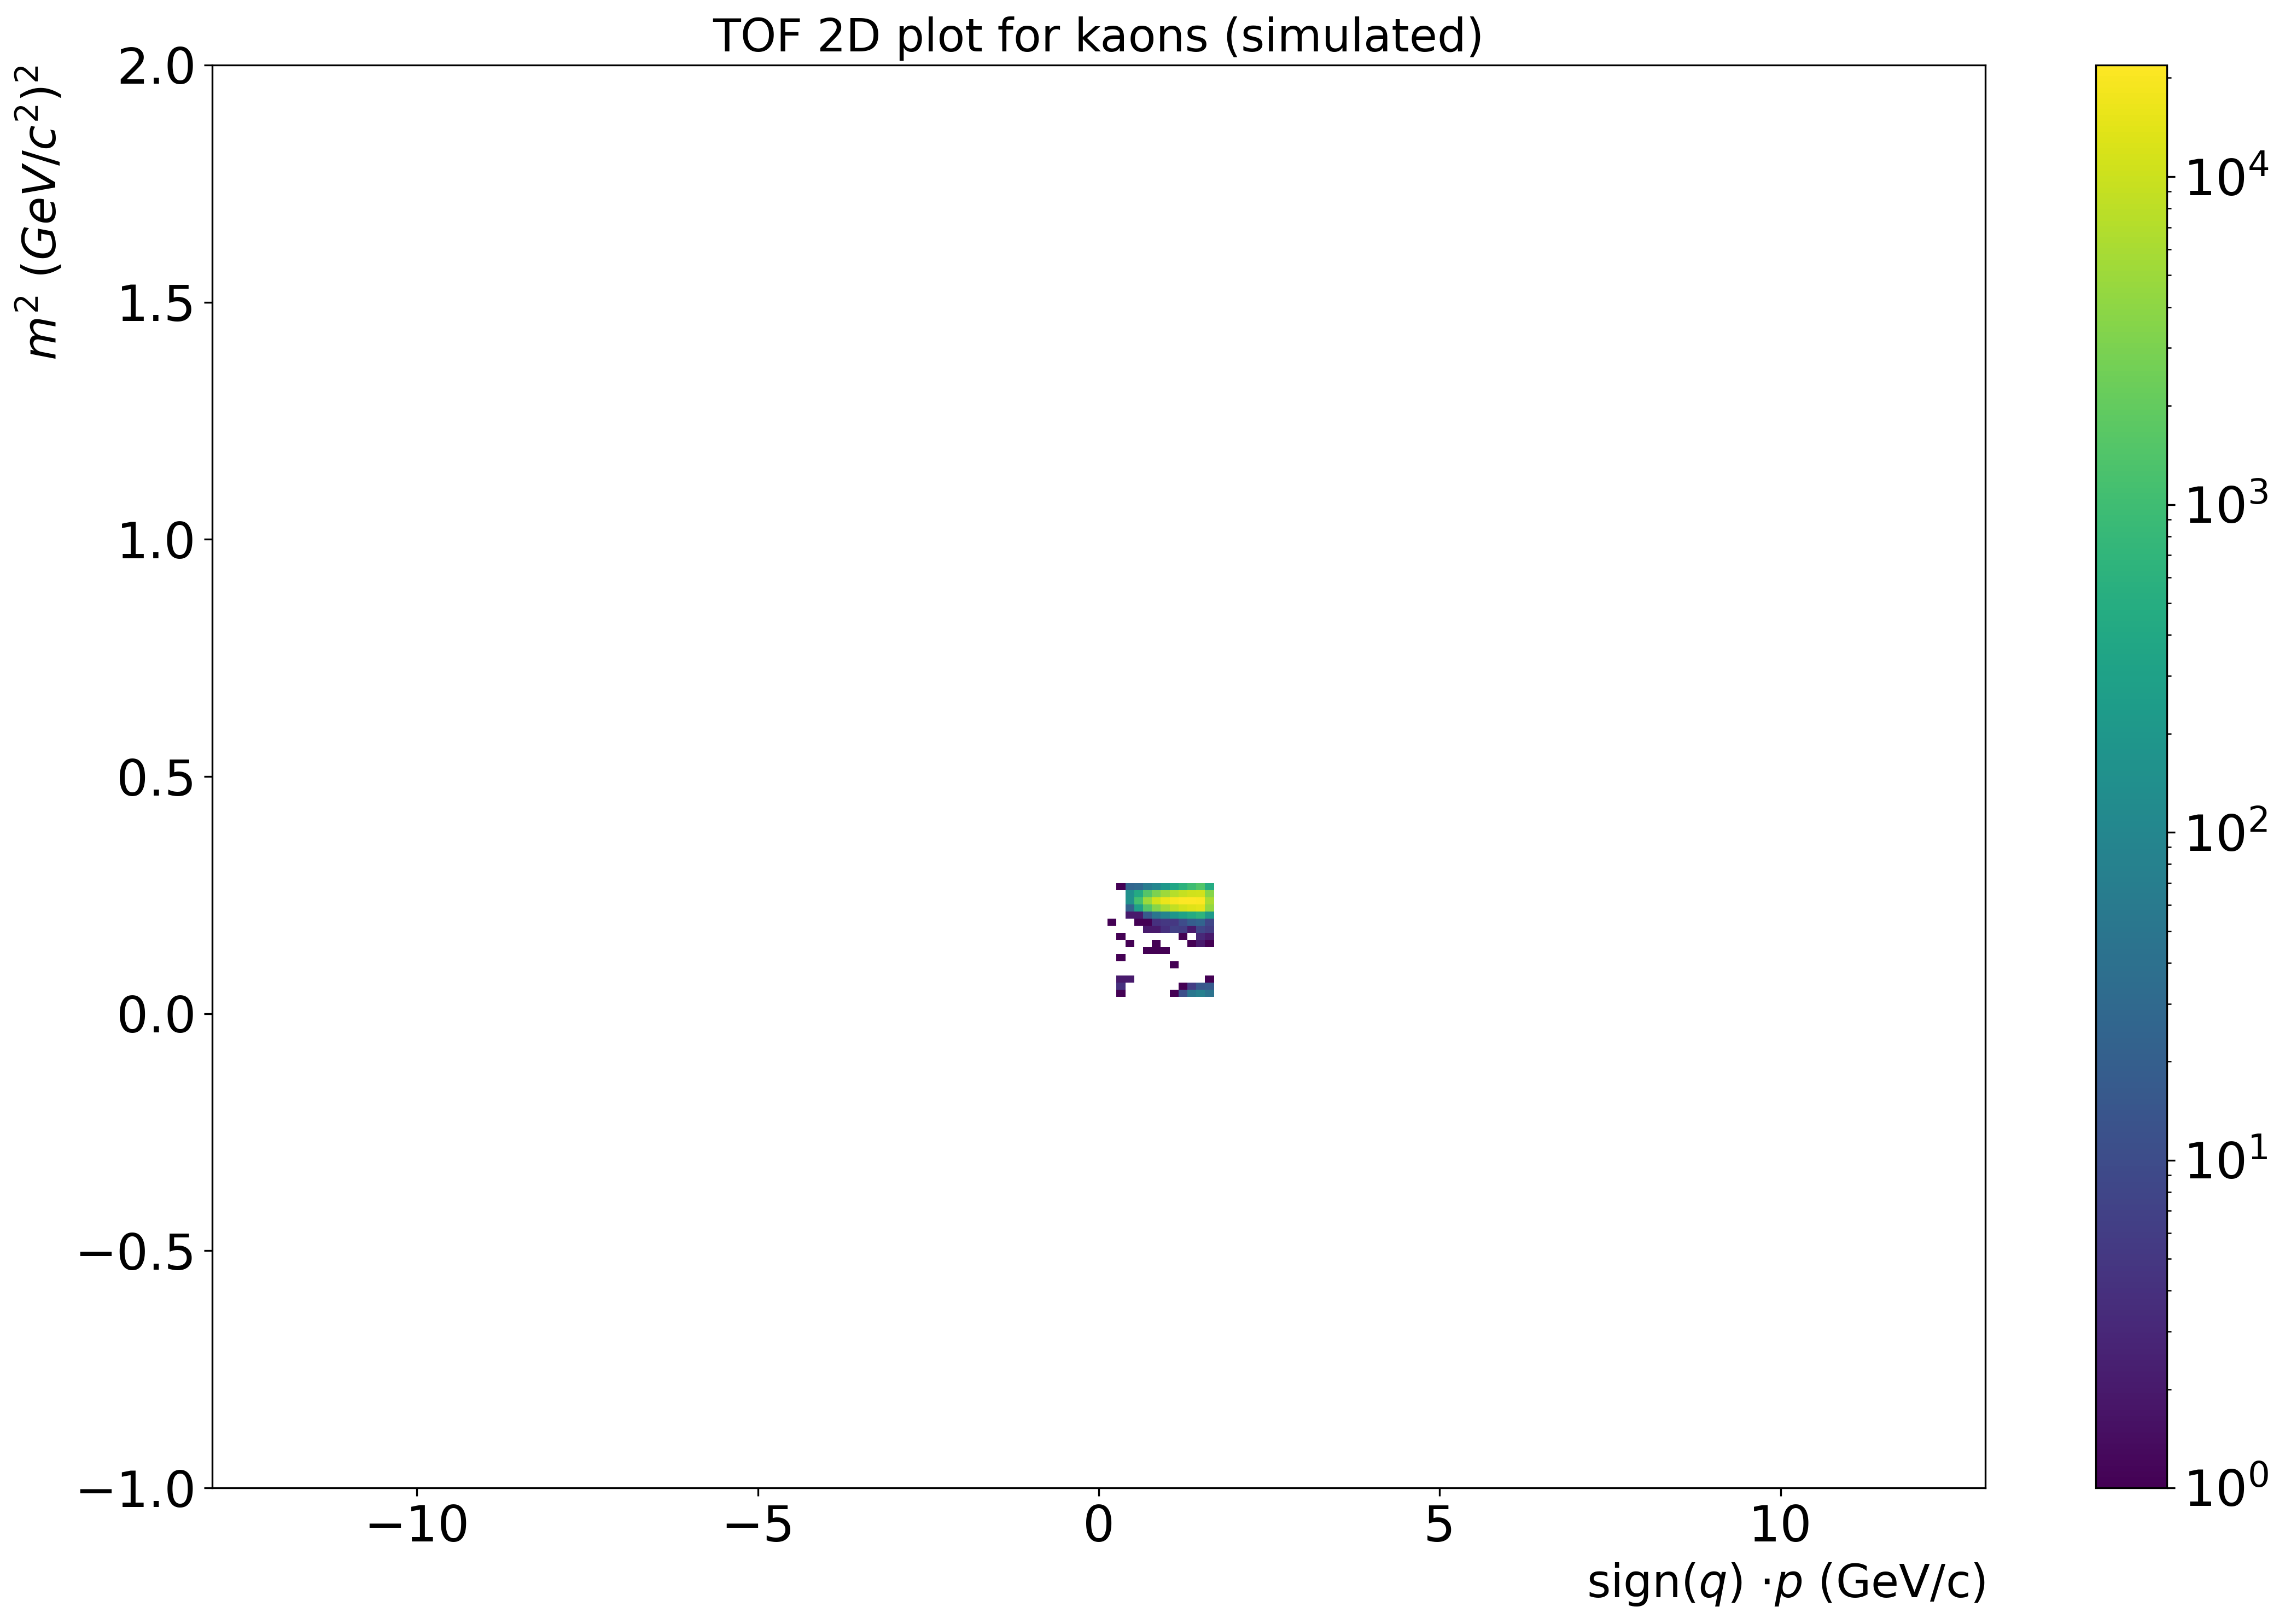

In [5]:
plotting_tools.tof_plot(
            df[df["xgb_preds"] == 1],
            json_file_name,
            f"kaons (simulated)",
            save_fig=False,
        )

Let's take a closer look at xgb-selected protons with $$mass^2 < 0.4$$ which are MC-true kaons

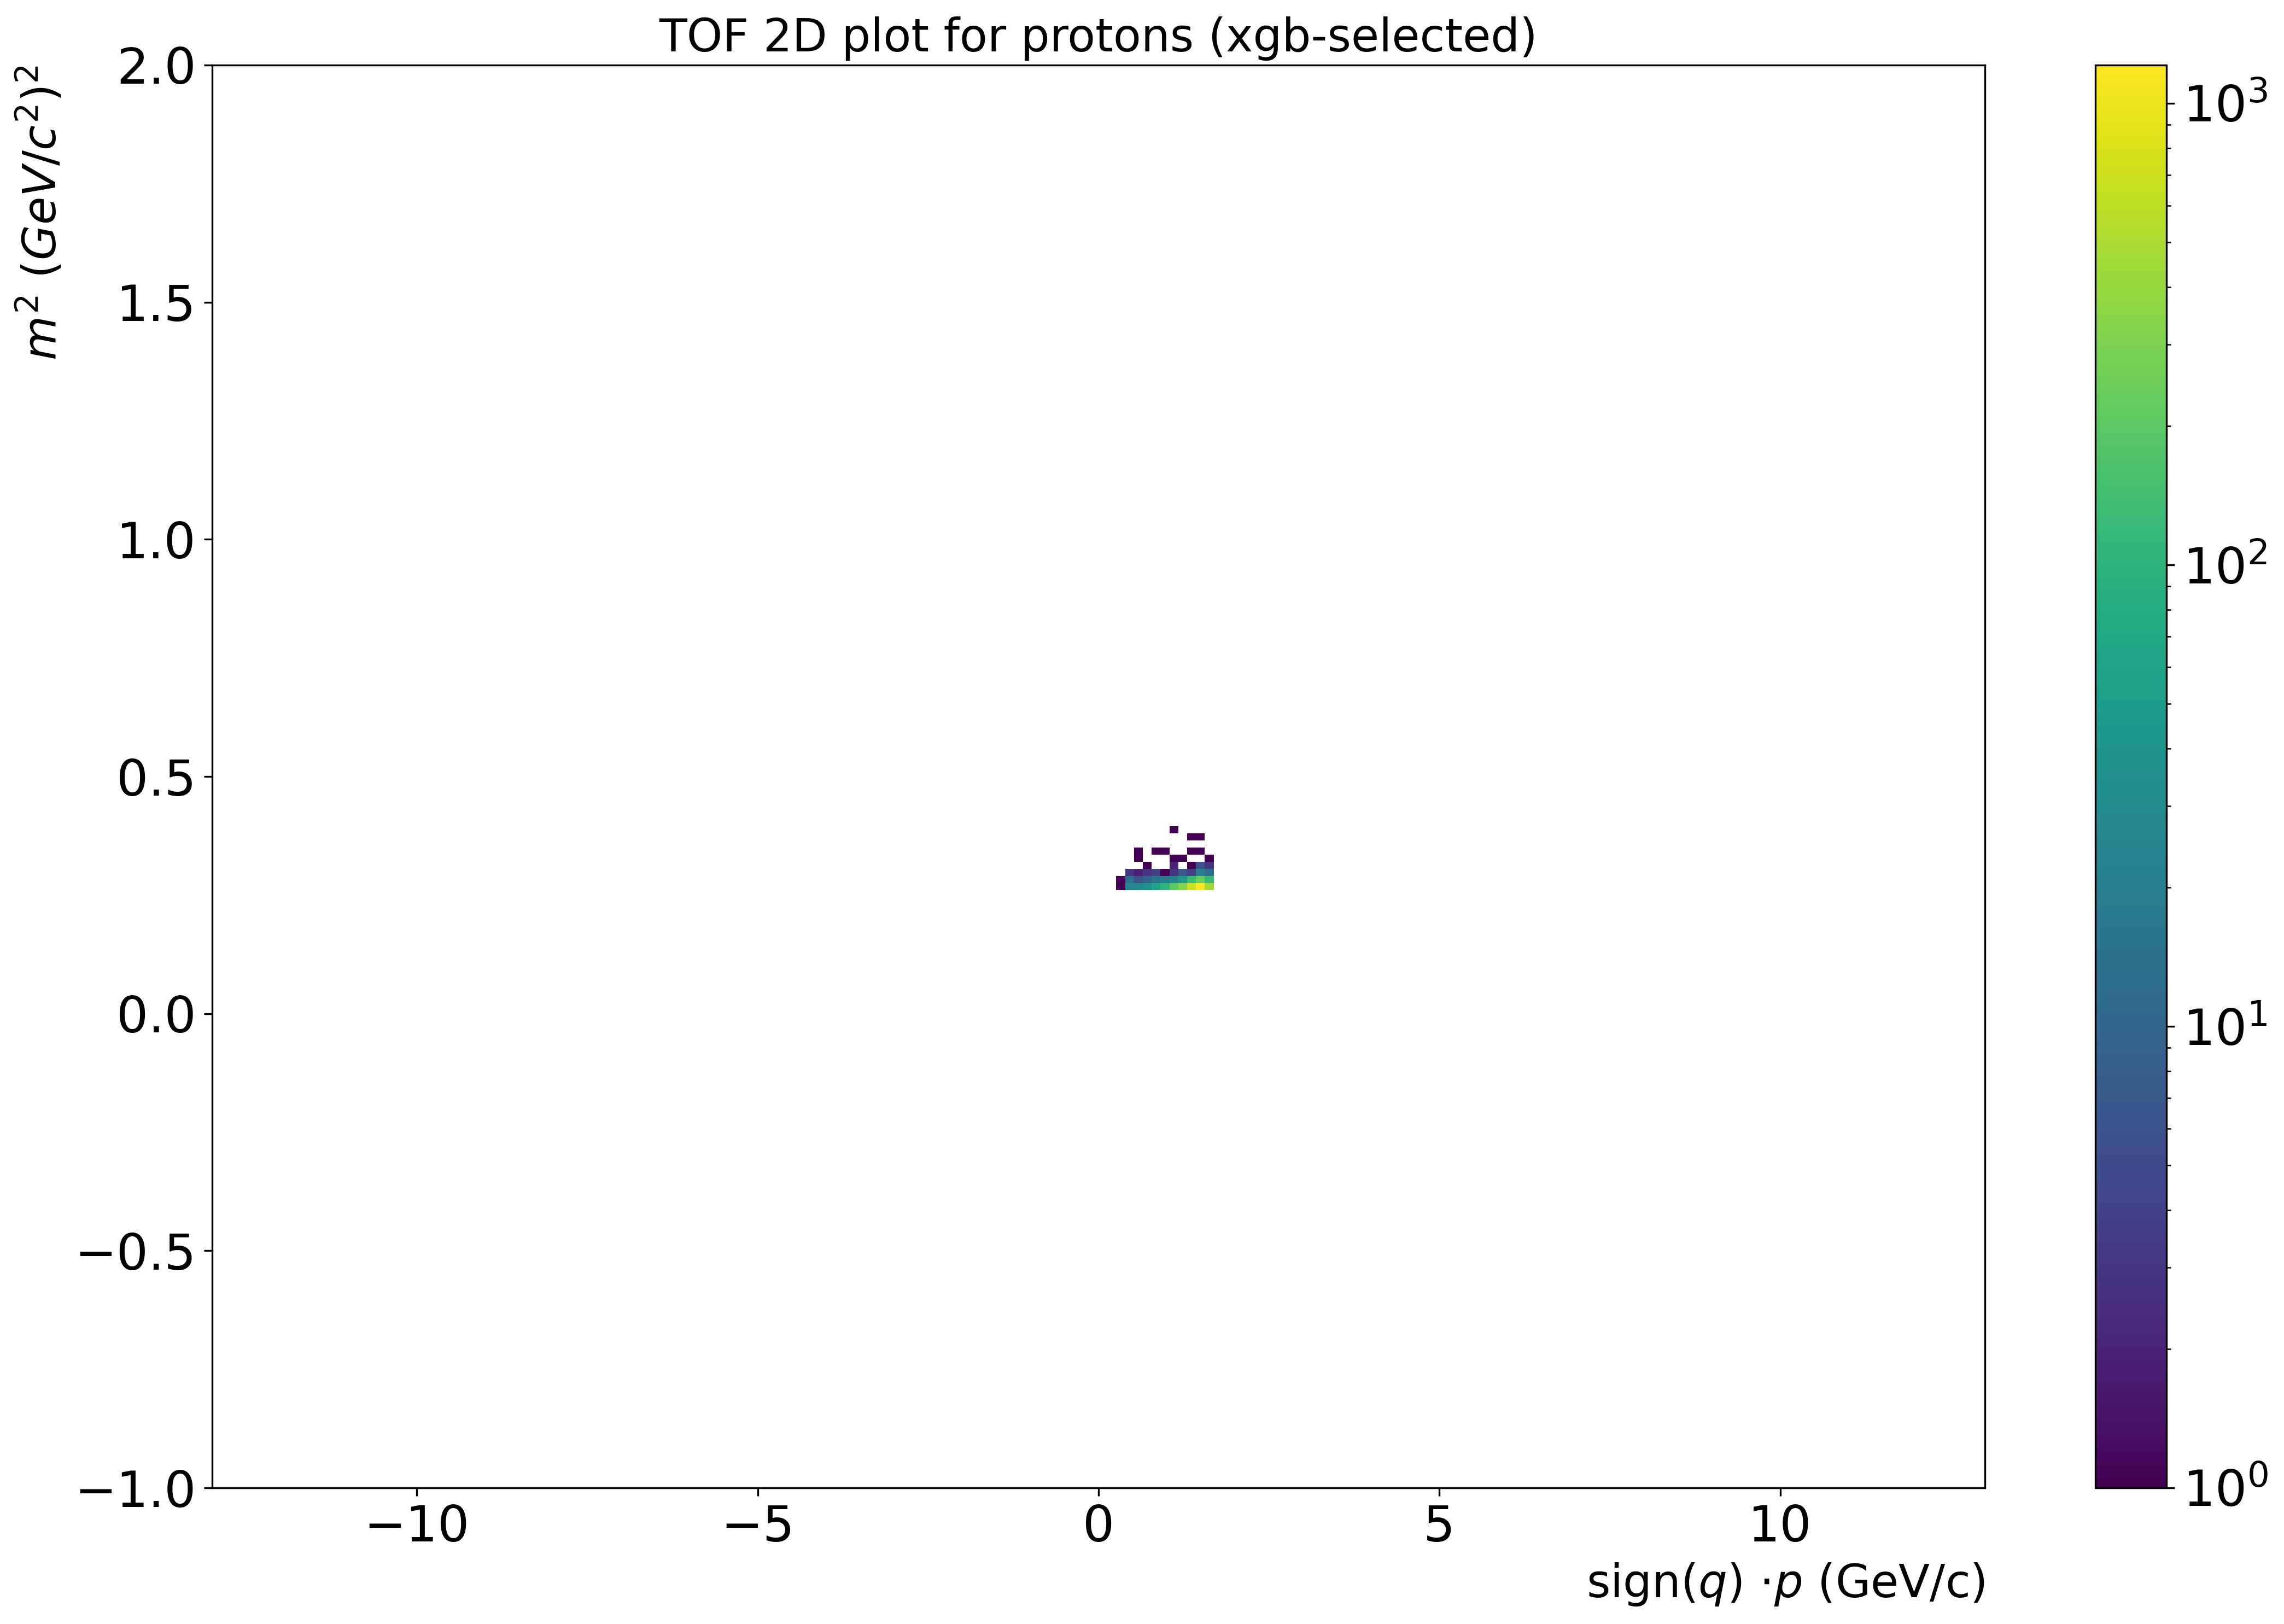

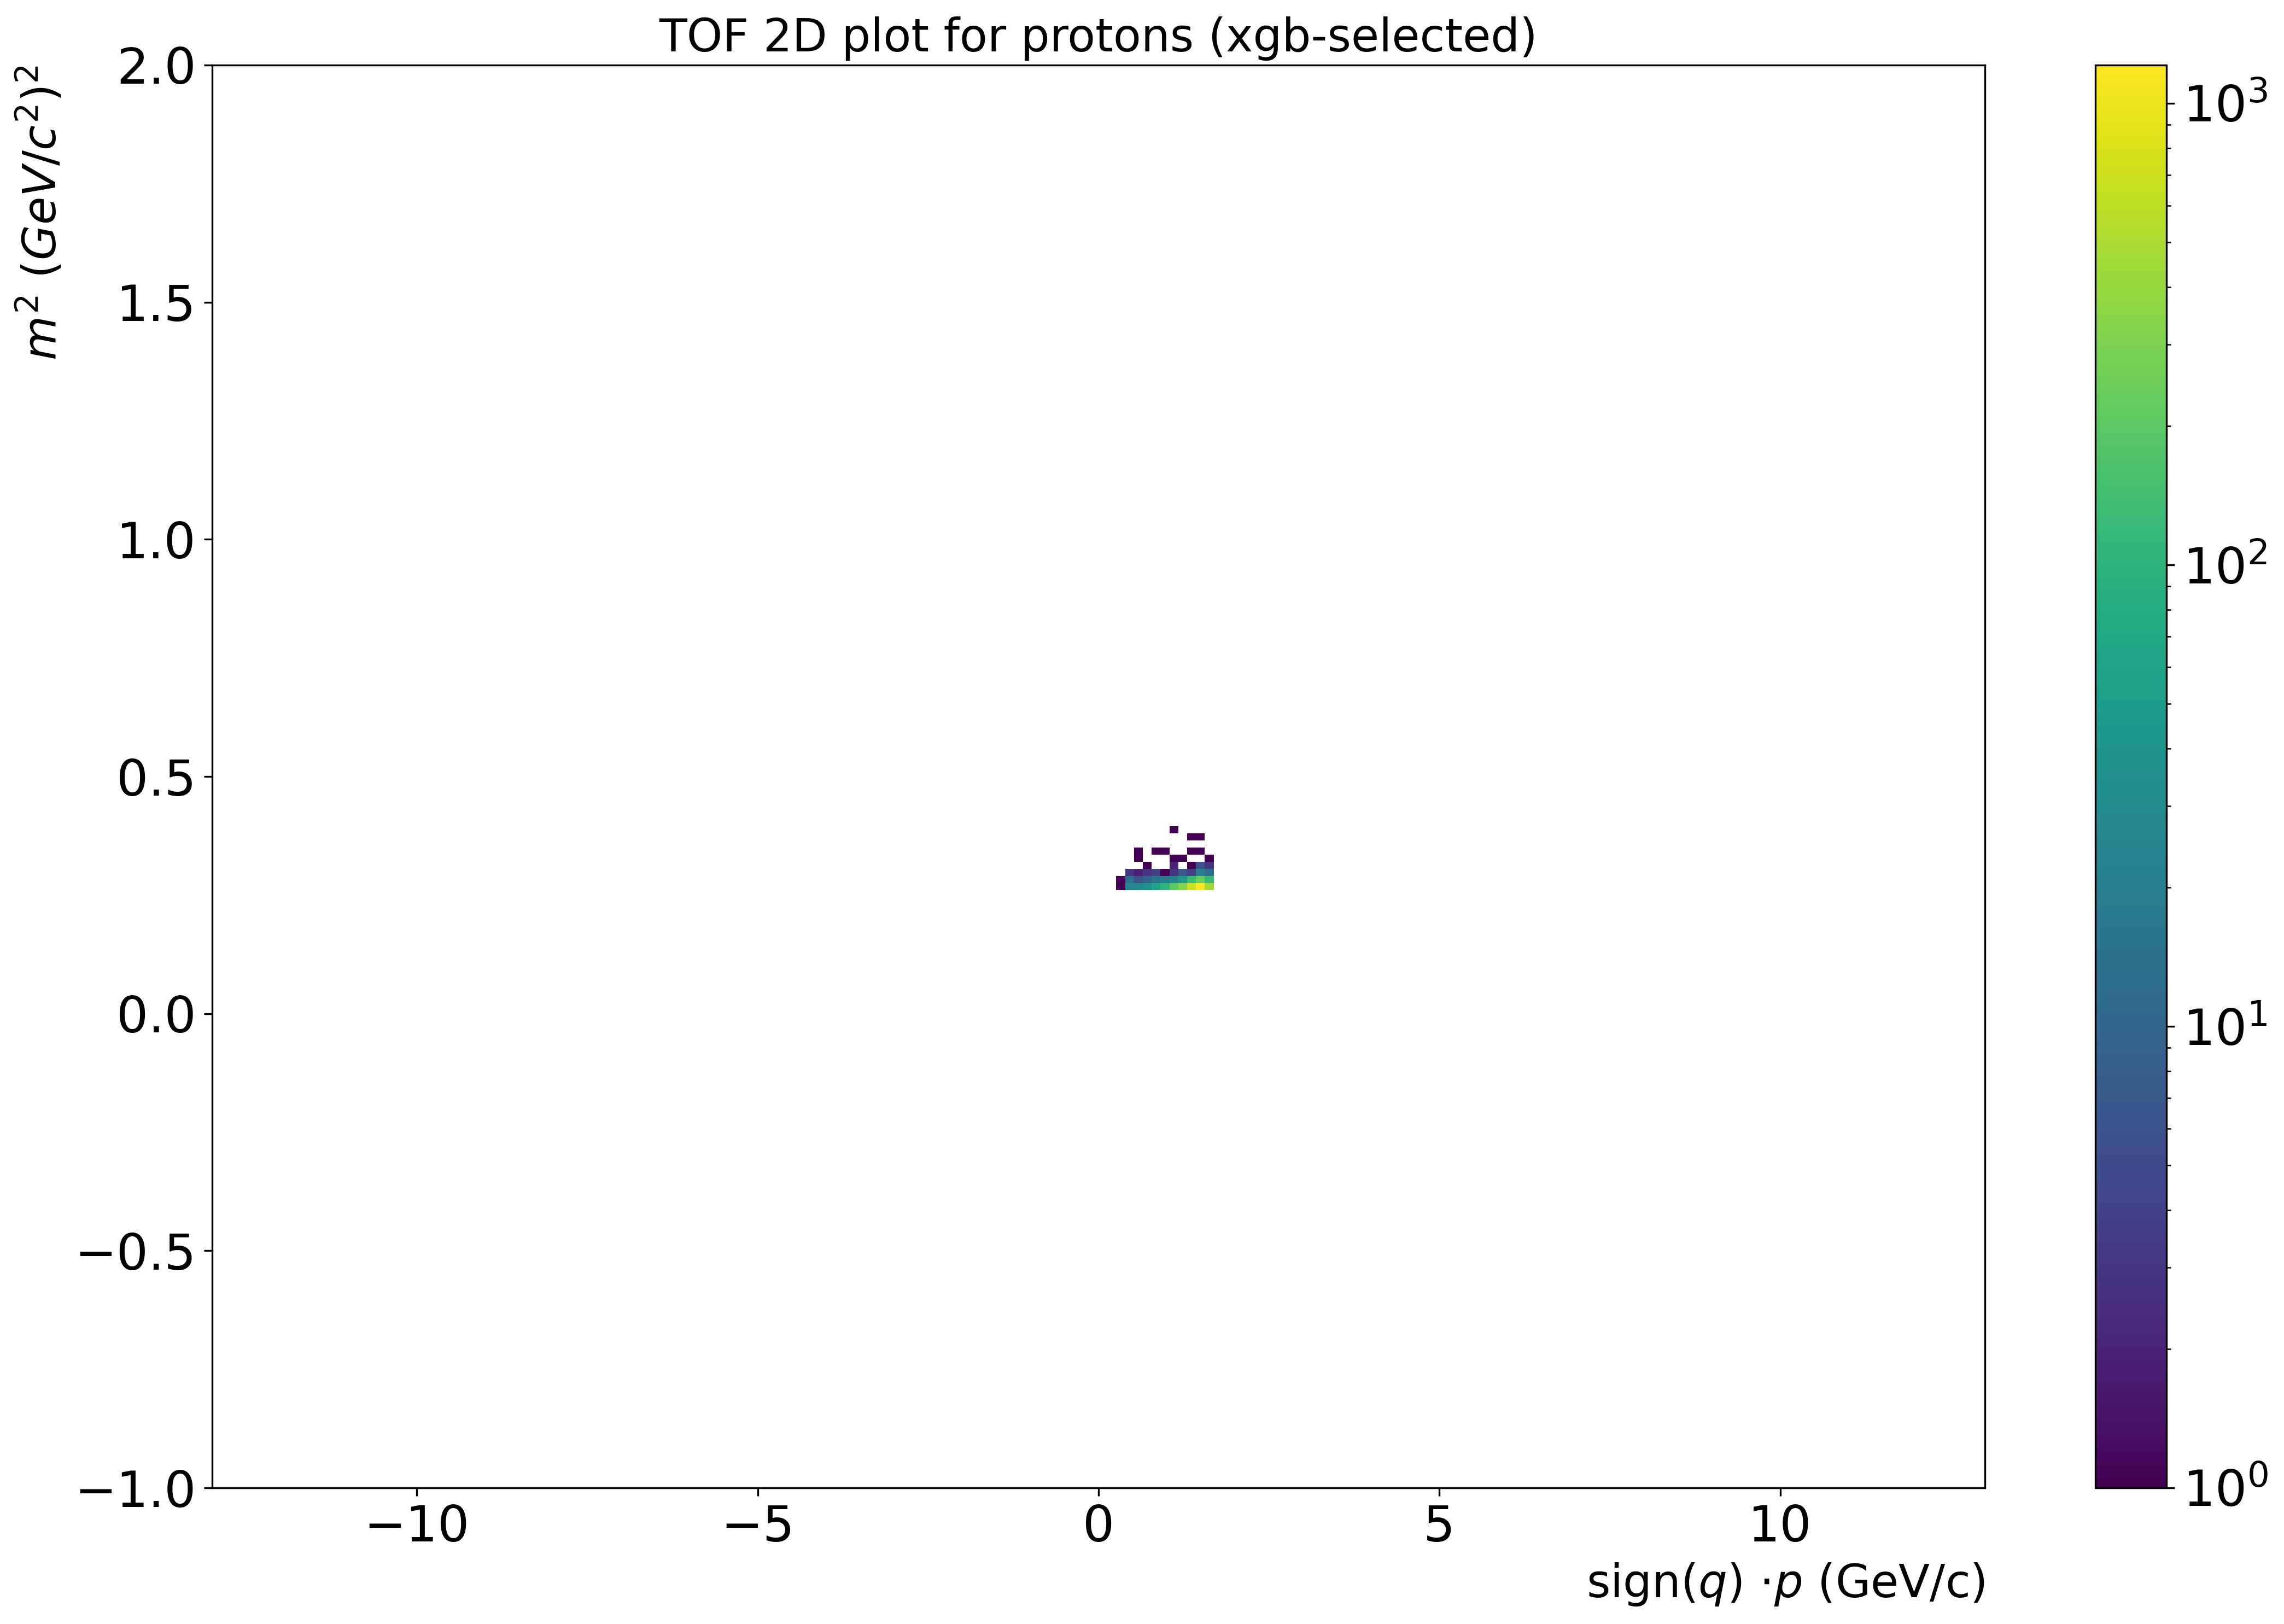

In [27]:
investigate_df = df[(df["xgb_preds"] == 0) & (df["Complex_mass2"] < .4) & (df["Complex_pid"] == 1)]
plotting_tools.tof_plot(
            investigate_df,
            json_file_name,
            f"protons (xgb-selected)",
            save_fig=False,
        )

In [32]:
#lets prepare shap explainer
features_for_train = json_tools.load_features_for_train(json_file_name)
model_hdl = ModelHandler()
model_hdl.load_model_handler(model_name)
feature_names = [item.replace("Complex_", "") for item in features_for_train]
explainer = shap.TreeExplainer(
        model_hdl.get_original_model(), n_jobs=8, approximate=False
    )
shap_values = explainer.shap_values(investigate_df[features_for_train])

Let's take a look at the first, random particle in this group

In [33]:
investigated_row = investigate_df.head(1)
investigated_row

,Complex_E,Complex_T,Complex_chi2_ov_ndf_vtx,Complex_eta,Complex_l,Complex_mass,Complex_mass2,Complex_p,Complex_pT,Complex_phi,...,Complex_vtx_chi2,Complex_M,Complex_id,Complex_mother_id,Complex_pid,Complex_q,model_output_0,model_output_1,model_output_2,xgb_preds
11318,1.472112,0.978435,0.813122,1.907837,762.136353,0.493677,0.266806,1.386866,0.402755,2.91642,...,0.643112,156.0,34.0,-1.0,1.0,1.0,0.816456,0.183529,0.000015,0


And especially its values which are used for training

In [43]:
investigated_row[features_for_train]

,Complex_mass2,Complex_vtx_chi2,Complex_chi2_ov_ndf_vtx
11318,0.266806,0.643112,0.813122


In [61]:
data = investigated_row[features_for_train].iloc[0]

lets check probability of this particle being a kaon

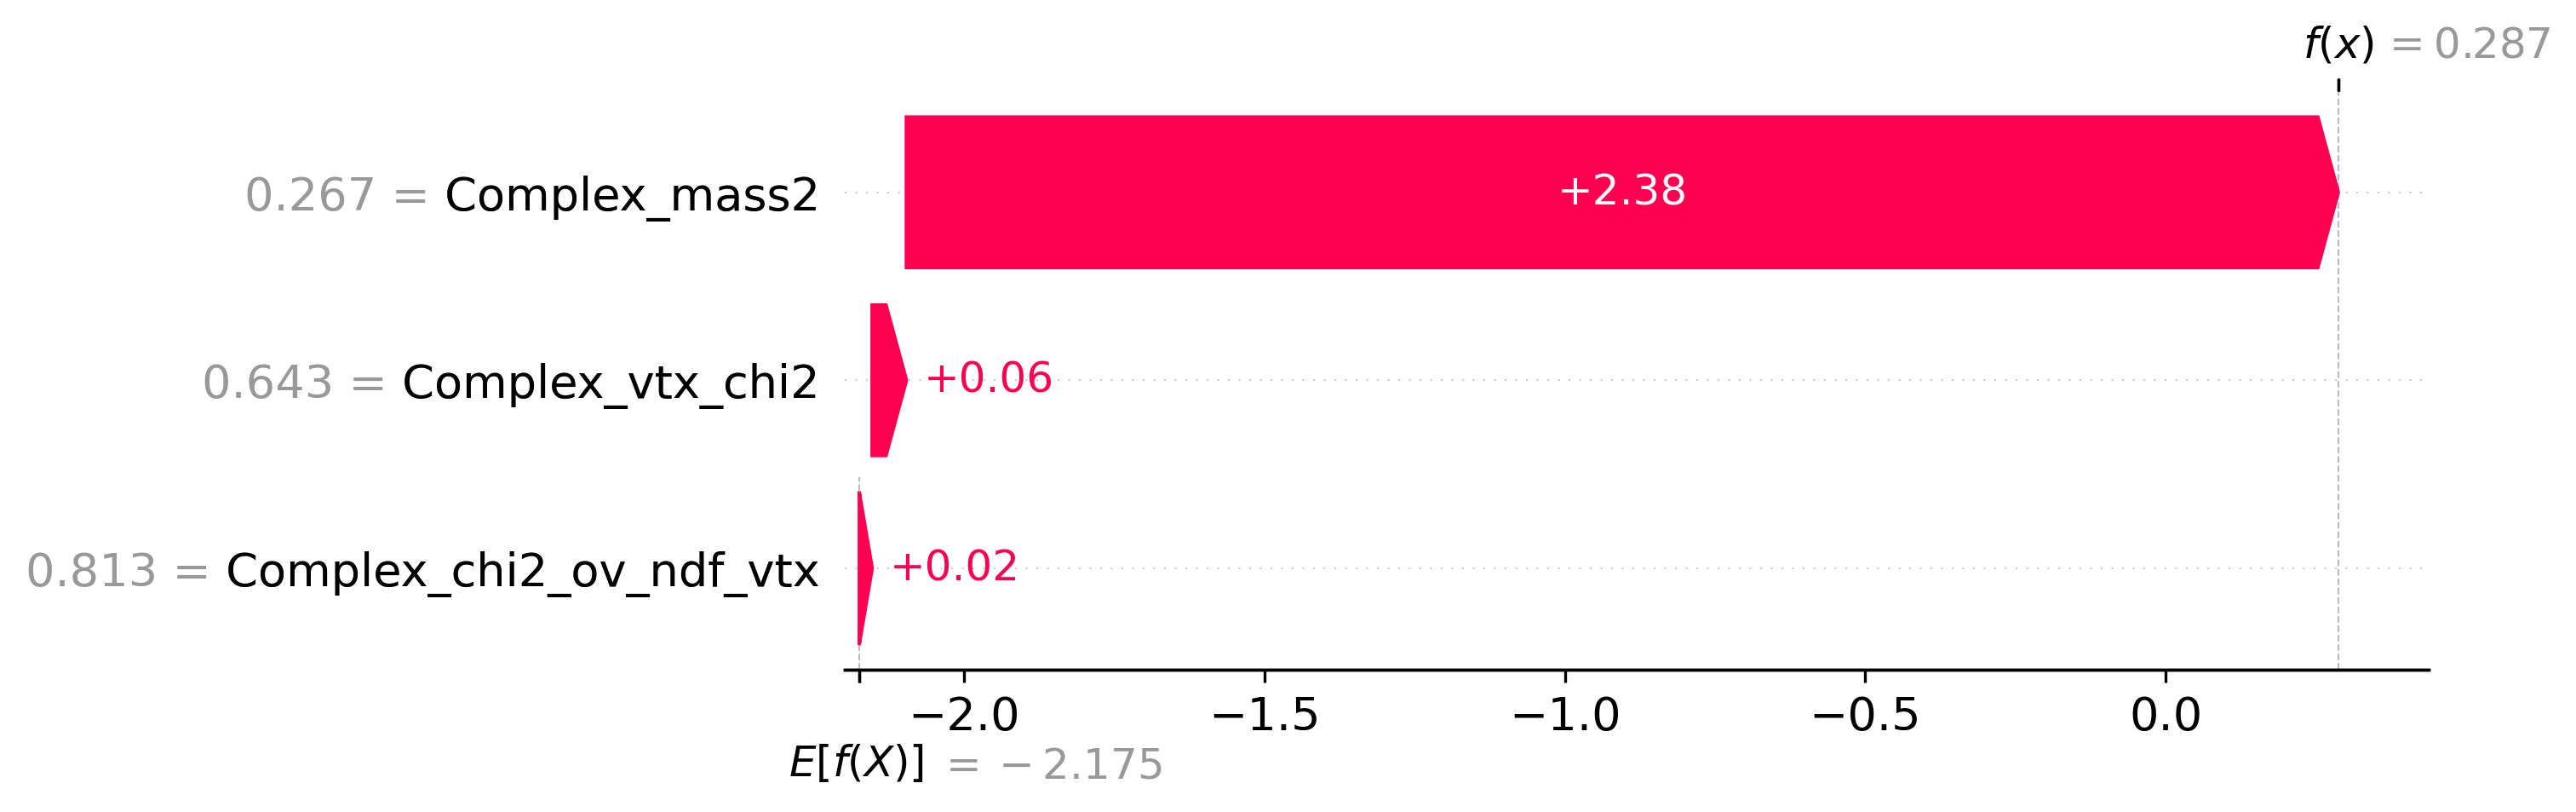

In [62]:
shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=data,
            feature_names=features_for_train,
        )
    )
)

And now being a proton

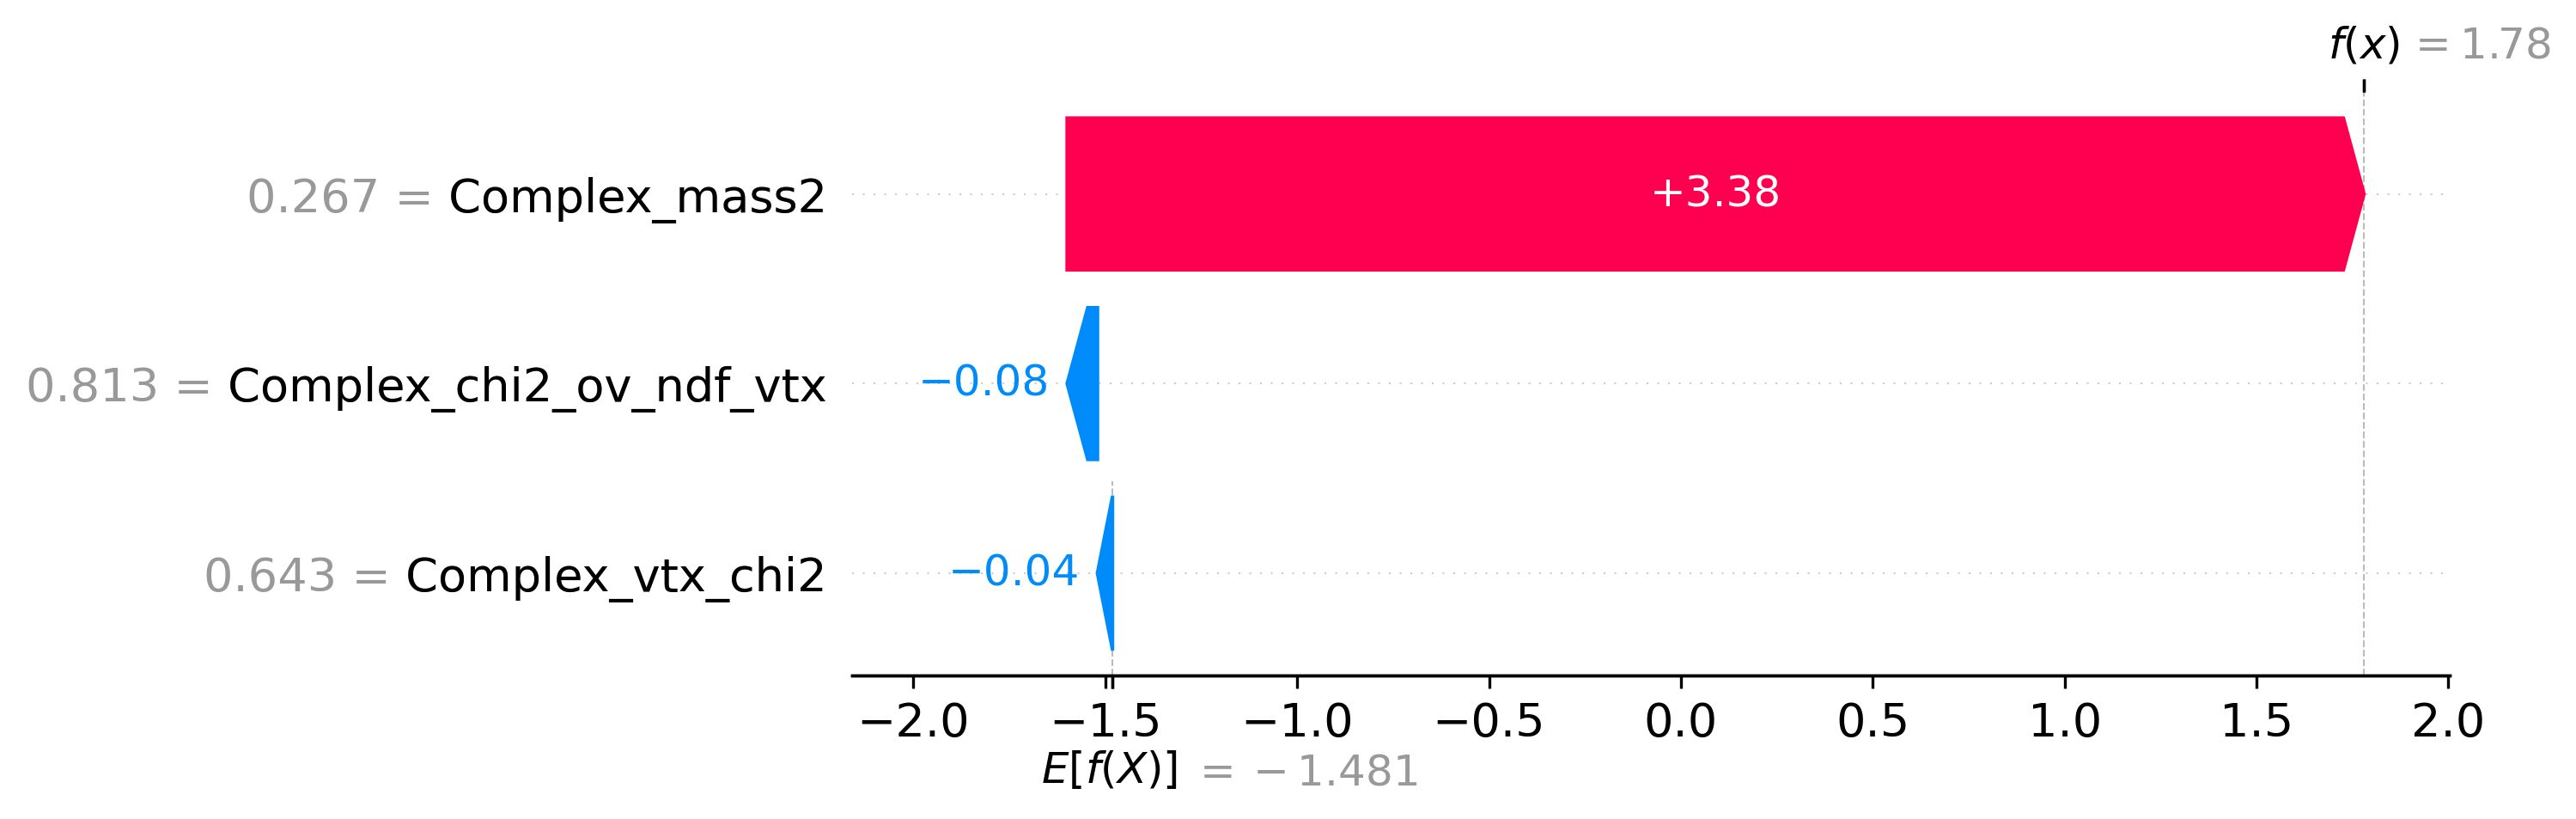

In [63]:

shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[0][0],
            base_values=explainer.expected_value[0],
            data=data,
            feature_names=features_for_train,
        )
    )
)

And maybe a pion?

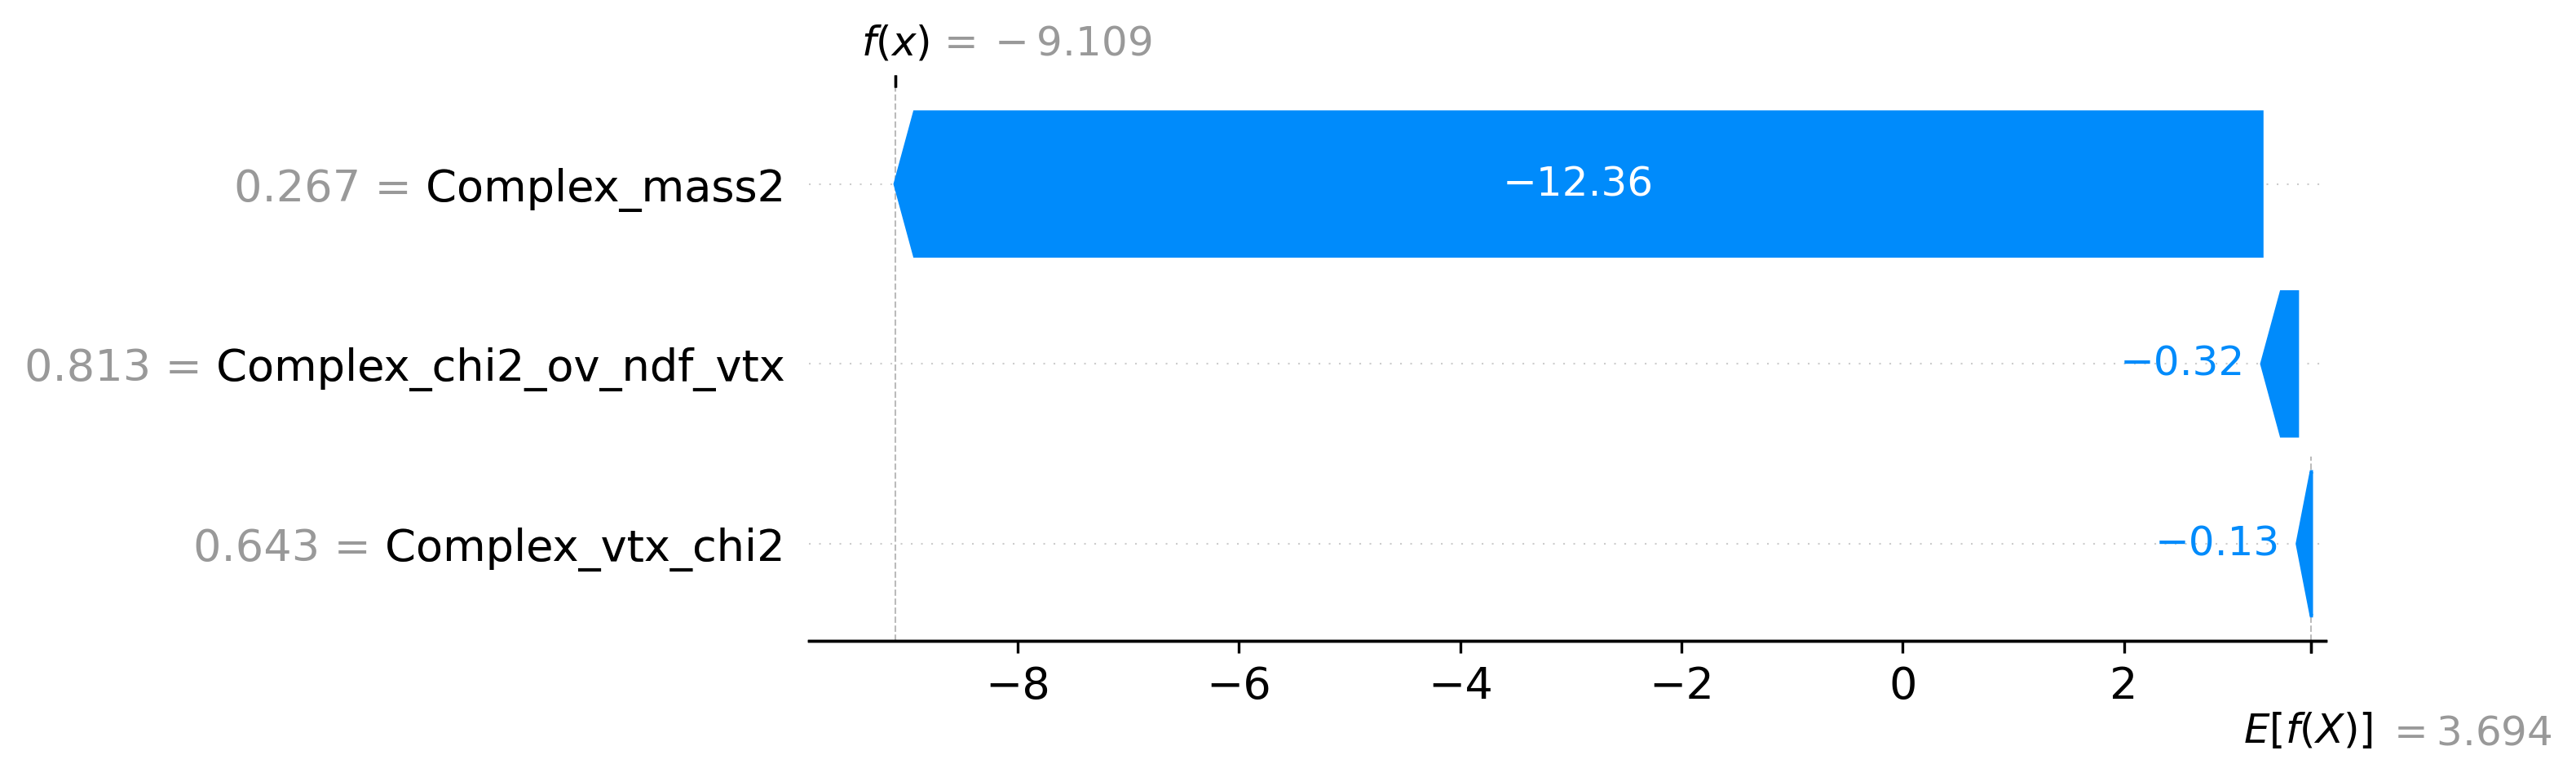

In [64]:

shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[2][0],
            base_values=explainer.expected_value[2],
            data=data,
            feature_names=features_for_train,
        )
    )
)

In summary, the base probability of a particle being a proton is higher than for a kaon, but also in this mass^2 region the probability is still higher for it to be a proton than a kaon